# Analisis dan Pemodelan Machine Learning Dataset Infrared

Dalam notebook ini, kita akan melakukan:
1. Eksplorasi Data (EDA)
2. Preprocessing dan Handling Missing Values
3. Feature Engineering
4. Pemodelan dengan Teknik Bagging (Random Forest)
5. Pemodelan dengan Teknik Boosting (Gradient Boosting, AdaBoost, XGBoost)
6. Evaluasi Model dengan RMSE, MSE, dan R-Squared

In [45]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from math import sqrt

# Set style untuk visualisasi
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Supaya output tidak terpotong
pd.set_option('display.max_columns', None)

## Fungsi Visualisasi Model

In [46]:
def visualize_regression_model(model_name, model_results, X_test, y_test, feature_names=None):
    """
    Visualisasi komprehensif untuk model regresi
    """
    model = model_results['model']
    y_test_pred = model_results['y_test_pred']

    # 1. Scatter plot Prediksi vs Aktual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'Prediksi vs Aktual - {model_name}')
    plt.xlabel('Suhu Oral Aktual')
    plt.ylabel('Suhu Oral Prediksi')
    plt.grid(True)

    # Tambahkan R² ke plot
    r2 = model_results['test_r2']
    rmse = model_results['test_rmse']
    plt.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.4f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout()
    plt.show()

    # 2. Plot Residual
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Plot Residual - {model_name}')
    plt.xlabel('Suhu Oral Prediksi')
    plt.ylabel('Residual (Aktual - Prediksi)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Histogram Residual
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, alpha=0.6, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Distribusi Residual - {model_name}')
    plt.xlabel('Residual')
    plt.ylabel('Frekuensi')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4. Feature Importance (jika model mendukung)
    if hasattr(model, 'feature_importances_') and feature_names is not None:
        # Limit jumlah fitur yang ditampilkan
        n_features = min(15, len(feature_names))
        importances = model.feature_importances_

        # Menangani kasus jika jumlah feature_names tidak sama dengan importances
        if len(feature_names) >= len(importances):
            feature_names = feature_names[:len(importances)]
        else:
            # Tambahkan unnamed features jika kurang
            feature_names = feature_names + [f"Feature_{i}" for i in range(len(feature_names), len(importances))]

        # Sort berdasarkan importance
        indices = np.argsort(importances)[-n_features:]

        plt.figure(figsize=(10, 8))
        plt.barh(range(n_features), importances[indices])
        plt.yticks(range(n_features), [feature_names[i] for i in indices])
        plt.title(f'Top {n_features} Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

## 1. Membaca dan Mengeksplorasi Data

In [47]:
# Membaca data
infrared_df = pd.read_csv('Infrared.csv')

# Melihat 5 data pertama
print("Dimensi dataset:", infrared_df.shape)
infrared_df.head()

Dimensi dataset: (1020, 34)


,Gender,Age,Ethnicity,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,aveOralM
0,Male,41-50,White,24.0,28.0,0.8,0.7025,35.0300,35.3775,34.4000,34.9175,34.9850,34.9850,34.7625,35.0325,35.3375,35.3375,34.4850,35.3775,34.7850,34.4650,35.3775,35.3375,33.5775,33.4775,33.3725,33.4925,33.0025,34.5300,34.0075,35.6925,35.6350,35.6525,36.59
1,Female,31-40,Black or African-American,24.0,26.0,0.8,0.7800,34.5500,34.5200,33.9300,34.2250,34.7100,34.6325,34.6400,34.7425,34.5600,34.5375,34.3500,34.5750,34.3225,34.2400,34.7400,34.7150,34.0325,34.0550,33.6775,33.9700,34.0025,34.6825,34.6600,35.1750,35.0925,35.1075,37.19
2,Female,21-30,White,24.0,26.0,0.8,0.8625,35.6525,35.5175,34.2775,34.8000,35.6850,35.6675,35.6150,35.7175,35.5025,35.5025,35.2950,35.5300,35.3575,35.0925,35.7175,35.6825,34.9000,34.8275,34.6475,34.8200,34.6700,35.3450,35.2225,35.9125,35.8600,35.8850,37.34
3,Female,21-30,Black or African-American,24.0,27.0,0.8,0.9300,35.2225,35.6125,34.3850,35.2475,35.2075,35.2000,35.1175,35.2250,35.5950,35.5950,35.3275,35.6125,34.9100,35.1700,35.6125,35.5950,34.4400,34.4225,34.6550,34.3025,34.9175,35.6025,35.3150,35.7200,34.9650,34.9825,37.09
4,Male,18-20,White,24.0,27.0,0.8,0.8950,35.5450,35.6650,34.9100,35.3675,35.6025,35.4750,35.5700,35.6400,35.6400,35.6400,35.0775,35.6675,35.3550,35.1200,35.6650,35.6475,35.0900,35.1600,34.3975,34.6700,33.8275,35.4175,35.3725,35.8950,35.5875,35.6175,37.04


In [48]:
# Informasi data
infrared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Gender       1020 non-null   object 
 1   Age          1020 non-null   object 
 2   Ethnicity    1020 non-null   object 
 3   T_atm        1020 non-null   float64
 4   Humidity     1020 non-null   float64
 5   Distance     1018 non-null   float64
 6   T_offset1    1020 non-null   float64
 7   Max1R13_1    1020 non-null   float64
 8   Max1L13_1    1020 non-null   float64
 9   aveAllR13_1  1020 non-null   float64
 10  aveAllL13_1  1020 non-null   float64
 11  T_RC1        1020 non-null   float64
 12  T_RC_Dry1    1020 non-null   float64
 13  T_RC_Wet1    1020 non-null   float64
 14  T_RC_Max1    1020 non-null   float64
 15  T_LC1        1020 non-null   float64
 16  T_LC_Dry1    1020 non-null   float64
 17  T_LC_Wet1    1020 non-null   float64
 18  T_LC_Max1    1020 non-null   float64
 19  RCC1  

In [49]:
# Statistik deskriptif
infrared_df.describe()

,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,aveOralM
count,1020.000000,1020.000000,1018.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000
mean,24.115392,28.723039,0.729784,0.968648,35.596533,35.611474,34.888475,35.011345,35.659921,35.587143,35.547315,35.689762,35.640851,35.610869,35.468624,35.670962,35.253563,35.208961,35.787509,35.758025,34.573865,34.567782,34.565340,34.487701,34.577293,35.421555,35.094144,36.084785,35.805519,35.838277,37.028382
std,1.336338,13.071627,2.456486,0.362587,0.574888,0.549760,0.718613,0.633836,0.553897,0.569278,0.568828,0.553594,0.541169,0.545645,0.566434,0.540748,0.605968,0.584393,0.533453,0.533313,0.672461,0.669410,0.678663,0.668065,0.728678,0.523477,0.576045,0.491821,0.559258,0.559316,0.509502
min,20.200000,9.900000,0.540000,-0.590000,33.897500,34.122500,31.770000,32.902500,33.985000,33.825000,33.932500,34.002500,34.105000,34.105000,33.730000,34.122500,33.617500,33.385000,34.375000,34.352500,31.050000,31.452500,31.657500,31.280000,31.150000,33.407500,32.440000,34.892500,33.802500,33.835000,35.540000
25%,23.400000,17.600000,0.600000,0.772500,35.247500,35.271875,34.456250,34.651250,35.332500,35.249375,35.210000,35.360000,35.309375,35.278750,35.127500,35.331875,34.886250,34.863750,35.455000,35.426875,34.213125,34.180000,34.177500,34.096875,34.225000,35.116875,34.756458,35.775000,35.474375,35.500000,36.777500
50%,24.000000,26.300000,0.620000,0.940000,35.548750,35.575000,34.915000,34.997500,35.602500,35.533750,35.482500,35.631250,35.597500,35.572500,35.425000,35.626250,35.203750,35.167500,35.713750,35.686250,34.605000,34.597500,34.602500,34.512917,34.622500,35.391250,35.100000,36.027500,35.790000,35.825000,36.940000
75%,24.700000,36.200000,0.700000,1.140000,35.872500,35.883125,35.300000,35.363125,35.910625,35.855625,35.808125,35.940625,35.895000,35.863125,35.755000,35.922500,35.562500,35.498125,36.030625,36.002500,34.965625,34.968125,34.965000,34.878125,35.012500,35.675000,35.415000,36.280000,36.087500,36.120625,37.140000
max,29.100000,61.200000,79.000000,2.875000,38.405000,38.042500,37.575000,37.680000,38.385000,38.380000,38.330000,38.407500,38.042500,38.037500,37.960000,38.075000,38.155000,37.827500,38.407500,38.382500,37.125000,37.075000,37.165000,37.212500,37.367500,38.002500,37.632500,38.807500,38.417500,38.455000,40.340000


In [50]:
# Memeriksa missing values
missing_values = infrared_df.isnull().sum()
missing_percentage = (missing_values / len(infrared_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Values:")
missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)

Missing Values:


,Missing Values,Percentage
Distance,2,0.196078


## 2. Exploratory Data Analysis (EDA)

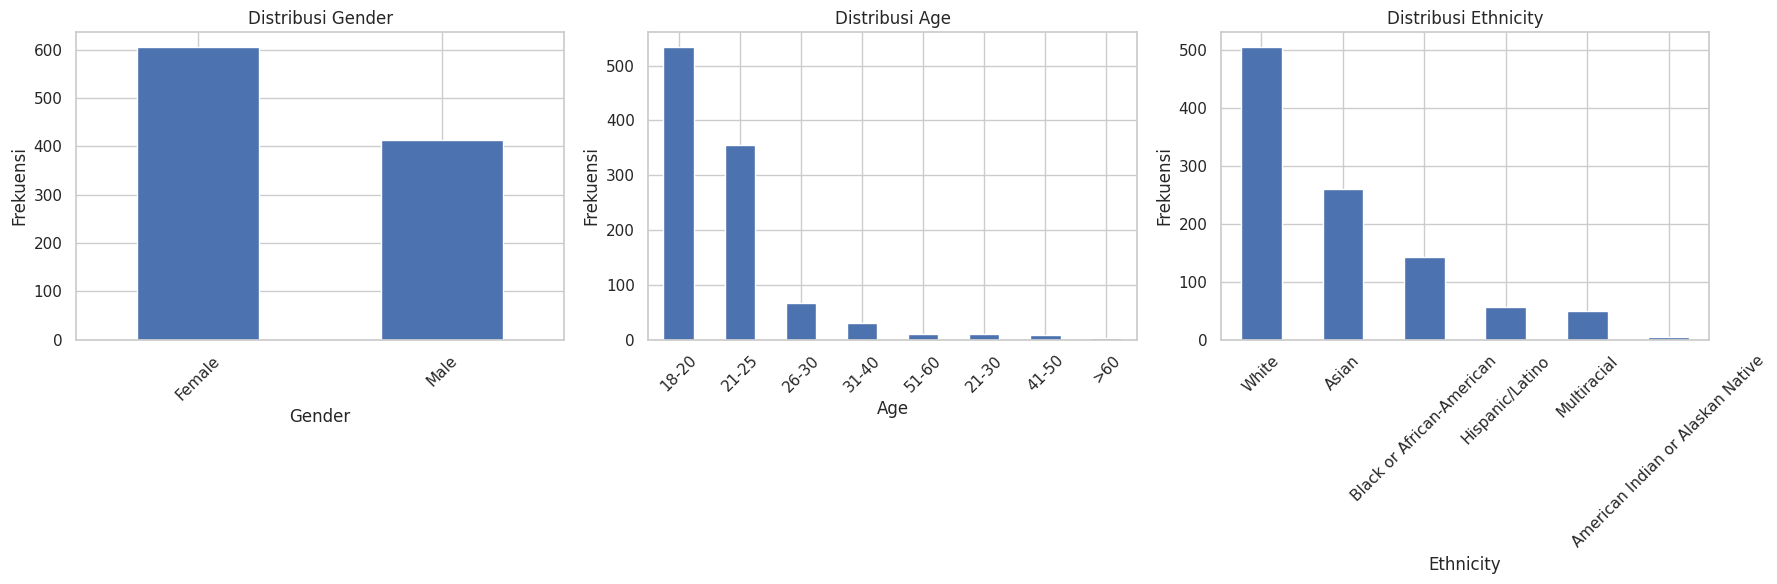

In [51]:
# Melihat distribusi kolom kategorikal
categorical_columns = ['Gender', 'Age', 'Ethnicity']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(categorical_columns):
    infrared_df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribusi {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frekuensi')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

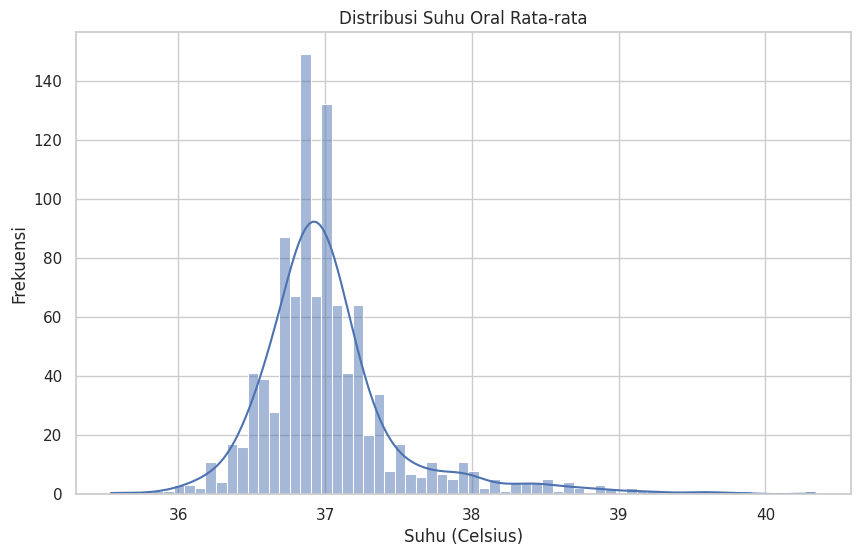

In [52]:
# Analisis fitur-fitur numerik
# Karena dataset ini memiliki banyak fitur, kita akan fokus pada beberapa fitur utama

# 1. Menganalisis korelasi terhadap suhu oral (aveOralM)
# aveOralM (suhu oral rata-rata) adalah target yang mungkin cocok untuk prediksi

# Melihat distribusi target (suhu oral rata-rata)
plt.figure(figsize=(10, 6))
sns.histplot(infrared_df['aveOralM'], kde=True)
plt.title('Distribusi Suhu Oral Rata-rata')
plt.xlabel('Suhu (Celsius)')
plt.ylabel('Frekuensi')
plt.show()

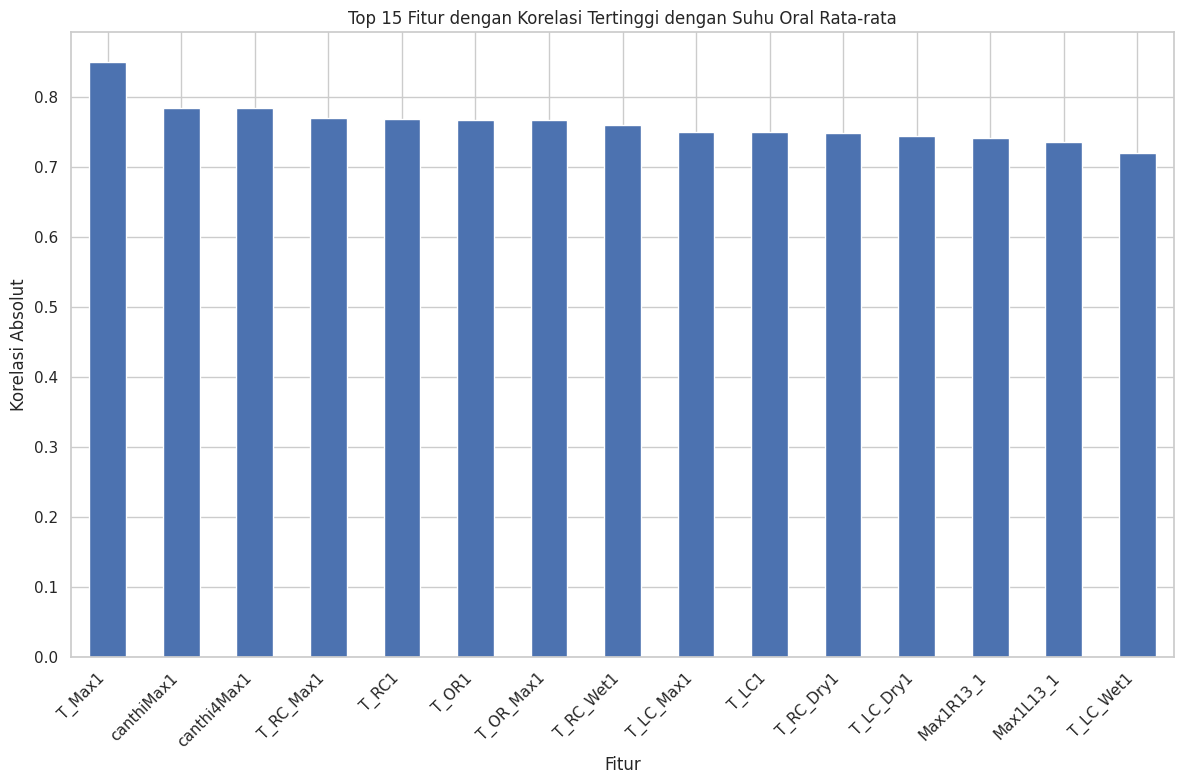

In [53]:
# Melihat korelasi antara fitur numerik dan target
numeric_features = infrared_df.select_dtypes(include=['float64', 'int64']).columns

# Menghitung korelasi dengan aveOralM
correlations = infrared_df[numeric_features].corrwith(infrared_df['aveOralM']).sort_values(ascending=False)

# Visualisasi korelasi dengan aveOralM
plt.figure(figsize=(12, 8))
correlations.drop('aveOralM').abs().sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Top 15 Fitur dengan Korelasi Tertinggi dengan Suhu Oral Rata-rata')
plt.xlabel('Fitur')
plt.ylabel('Korelasi Absolut')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

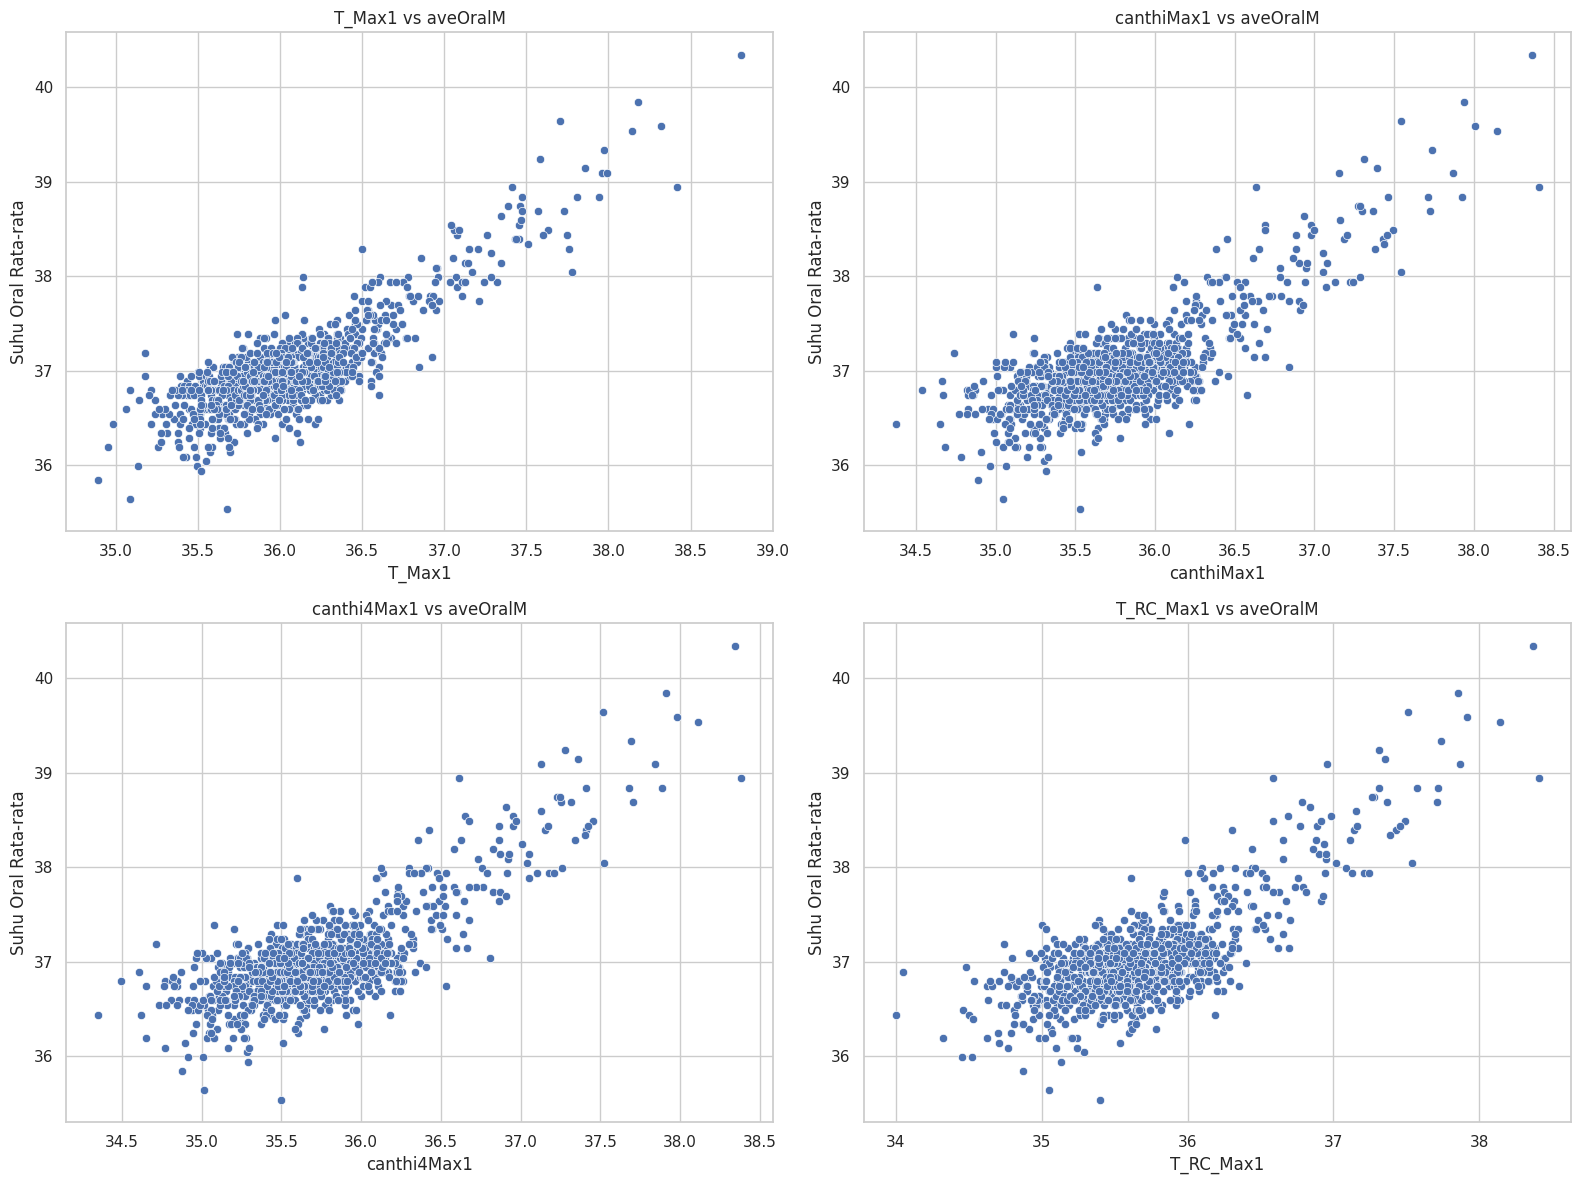

In [54]:
# Scatter plot untuk beberapa fitur dengan korelasi tertinggi
top_corr_features = correlations.drop('aveOralM').abs().sort_values(ascending=False).head(4).index

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(top_corr_features):
    sns.scatterplot(x=infrared_df[feature], y=infrared_df['aveOralM'], ax=axes[i])
    axes[i].set_title(f'{feature} vs aveOralM')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Suhu Oral Rata-rata')

plt.tight_layout()
plt.show()

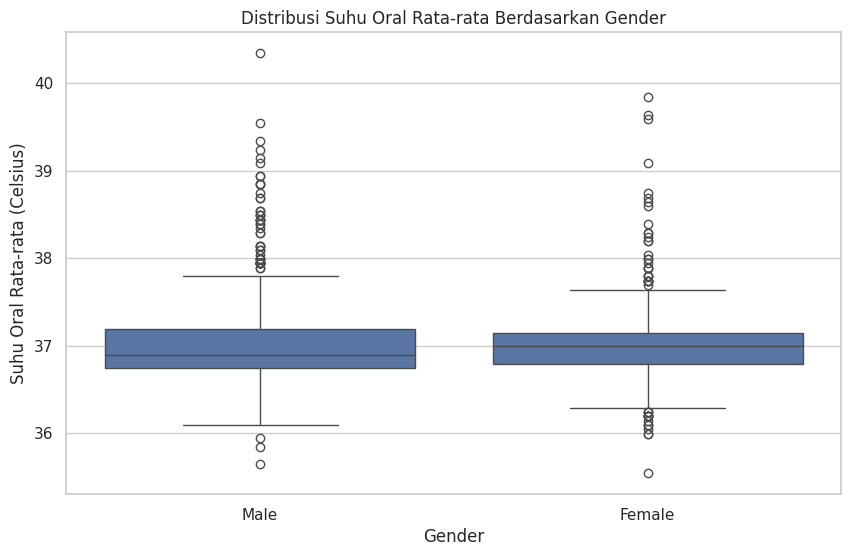

In [55]:
# Visualisasi suhu rata-rata berdasarkan Gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='aveOralM', data=infrared_df)
plt.title('Distribusi Suhu Oral Rata-rata Berdasarkan Gender')
plt.xlabel('Gender')
plt.ylabel('Suhu Oral Rata-rata (Celsius)')
plt.show()

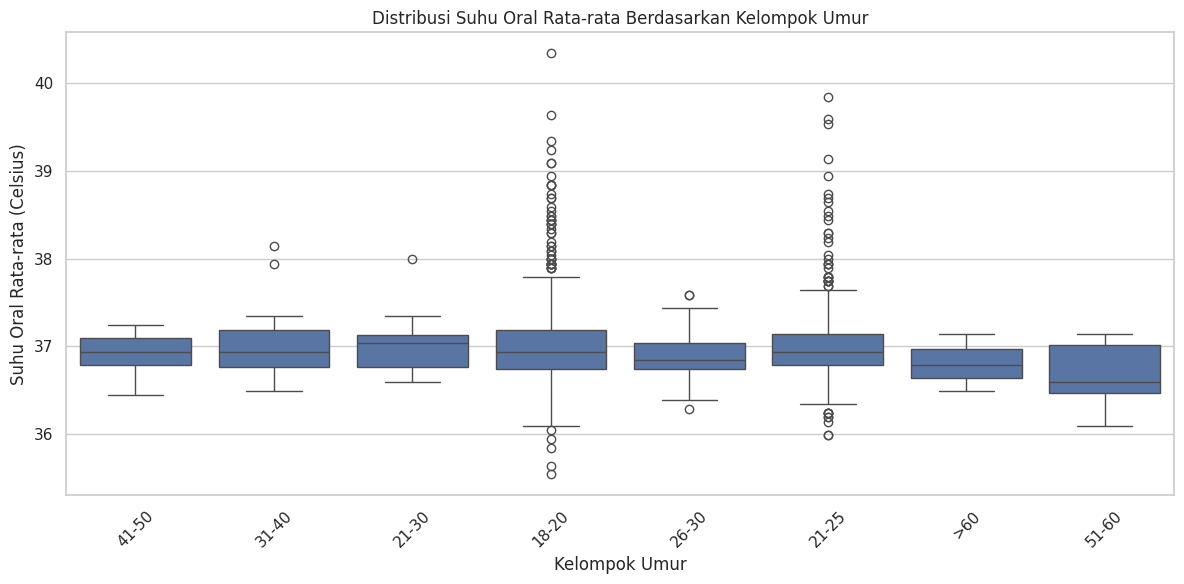

In [56]:
# Visualisasi suhu rata-rata berdasarkan Age
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', y='aveOralM', data=infrared_df)
plt.title('Distribusi Suhu Oral Rata-rata Berdasarkan Kelompok Umur')
plt.xlabel('Kelompok Umur')
plt.ylabel('Suhu Oral Rata-rata (Celsius)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

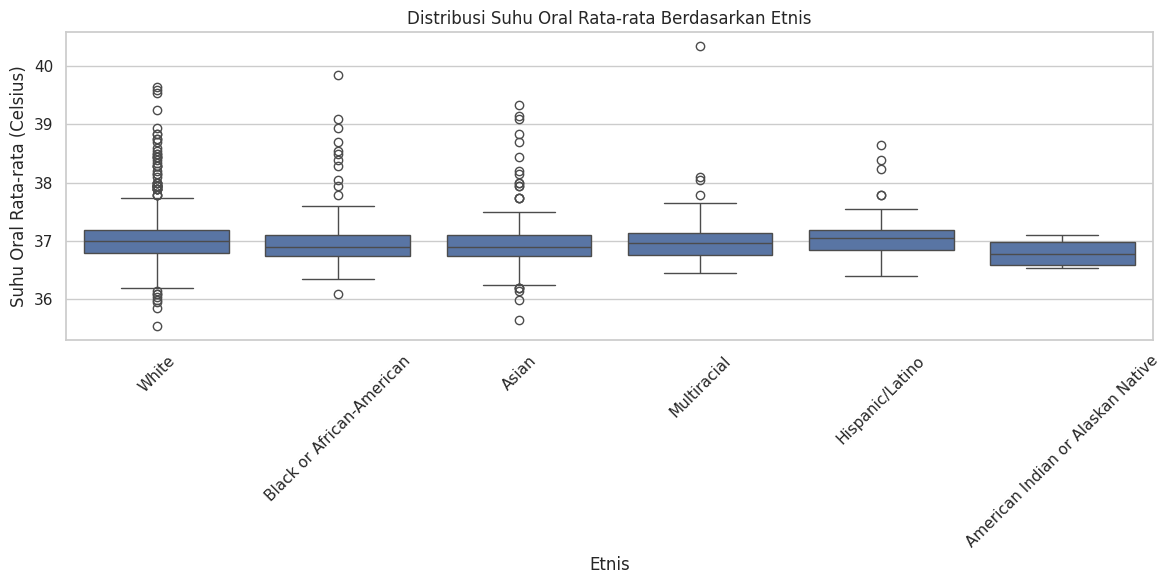

In [57]:
# Visualisasi suhu rata-rata berdasarkan Ethnicity
plt.figure(figsize=(12, 6))
sns.boxplot(x='Ethnicity', y='aveOralM', data=infrared_df)
plt.title('Distribusi Suhu Oral Rata-rata Berdasarkan Etnis')
plt.xlabel('Etnis')
plt.ylabel('Suhu Oral Rata-rata (Celsius)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

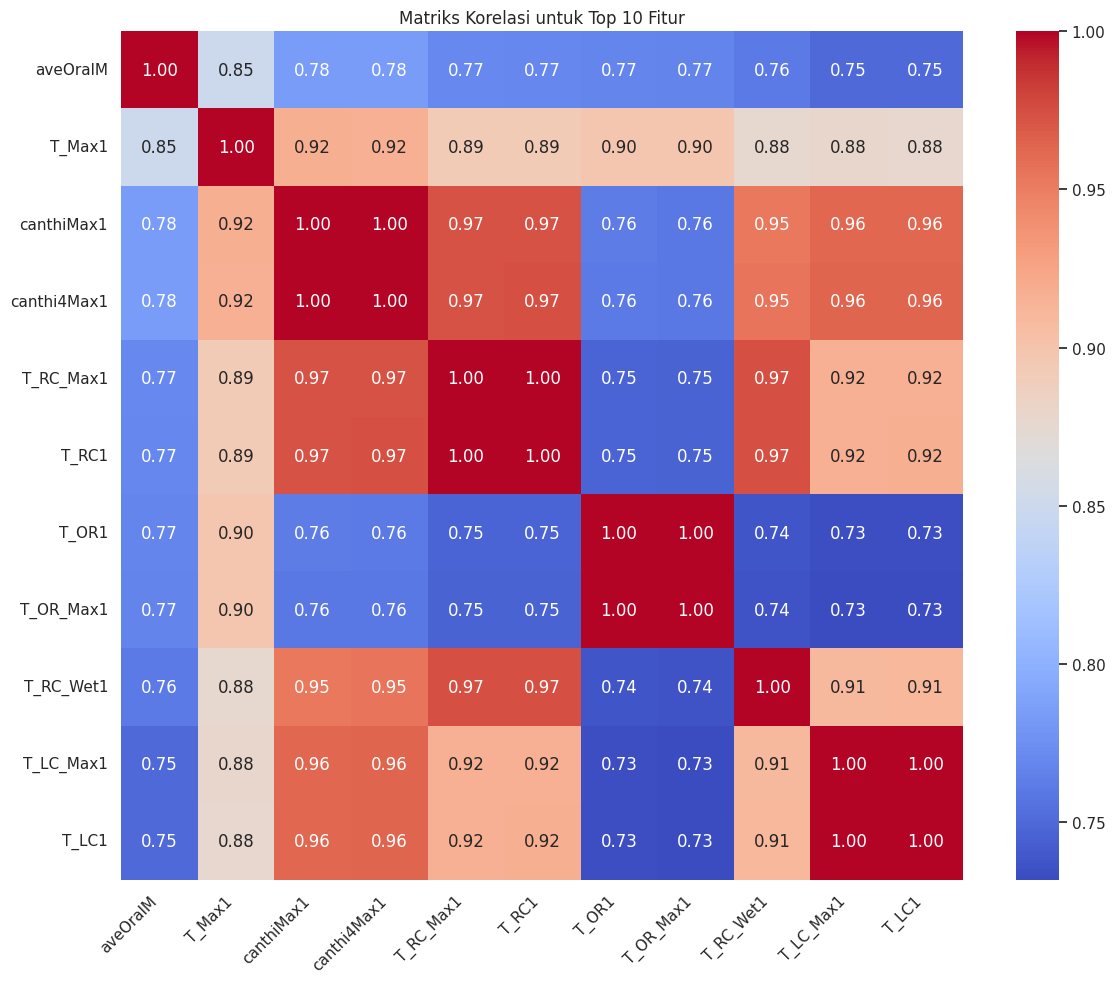

In [58]:
# Melihat korelasi antar fitur
# Karena terlalu banyak fitur, kita hanya lihat korelasi untuk top 10 fitur yang berkorelasi dengan target
top_features = correlations.abs().sort_values(ascending=False).head(11).index  # termasuk aveOralM

correlation_matrix = infrared_df[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriks Korelasi untuk Top 10 Fitur')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Menentukan Target dan Preprocessing Data

In [59]:
# Berdasarkan analisis data, kita akan memprediksi 'aveOralM' (suhu oral rata-rata)
# menggunakan fitur-fitur lain sebagai prediktor

# Memisahkan fitur dan target
X = infrared_df.drop('aveOralM', axis=1)
y = infrared_df['aveOralM']

# Identifikasi fitur kategorikal dan numerik
categorical_features = ['Gender', 'Age', 'Ethnicity']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Jumlah fitur kategorikal:", len(categorical_features))
print("Jumlah fitur numerik:", len(numeric_features))
# Memeriksa missing values pada target (aveOralM)
print(f"Jumlah nilai NaN dalam kolom target (aveOralM): {infrared_df['aveOralM'].isnull().sum()}")
print(f"Persentase nilai NaN dalam kolom target: {infrared_df['aveOralM'].isnull().sum() / len(infrared_df) * 100:.2f}%")

# Menghapus baris dengan nilai NaN pada target
infrared_df_clean = infrared_df.dropna(subset=['aveOralM'])
print(f"Jumlah baris sebelum menghapus NaN: {len(infrared_df)}")
print(f"Jumlah baris setelah menghapus NaN: {len(infrared_df_clean)}")

# Gunakan infrared_df_clean untuk analisis selanjutnya
infrared_df = infrared_df_clean.copy()

# Penanganan missing values pada fitur
# Tampilkan missing values pada fitur
missing_values = infrared_df.isnull().sum()
missing_percentage = (missing_values / len(infrared_df)) * 100
print("Missing values pada fitur:")
print(missing_values[missing_values > 0])

# Imputasi untuk fitur numerik
numeric_features = infrared_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_features:
    if infrared_df[col].isnull().sum() > 0:
        infrared_df[col].fillna(infrared_df[col].median(), inplace=True)

# Imputasi untuk fitur kategorikal
categorical_features = ['Gender', 'Age', 'Ethnicity']
for col in categorical_features:
    if infrared_df[col].isnull().sum() > 0:
        infrared_df[col].fillna(infrared_df[col].mode()[0], inplace=True)

# Verifikasi tidak ada lagi missing values
print("Missing values setelah imputasi:", infrared_df.isnull().sum().sum())

Jumlah fitur kategorikal: 3
Jumlah fitur numerik: 30
Jumlah nilai NaN dalam kolom target (aveOralM): 0
Persentase nilai NaN dalam kolom target: 0.00%
Jumlah baris sebelum menghapus NaN: 1020
Jumlah baris setelah menghapus NaN: 1020
Missing values pada fitur:
Distance    2
dtype: int64
Missing values setelah imputasi: 0


<ipython-input-59-9973831d8ffb>:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  infrared_df[col].fillna(infrared_df[col].median(), inplace=True)


In [60]:
# 1. Pastikan pembagian fitur dan target dilakukan dengan benar
# Tampilkan nama kolom untuk memastikan
print("Nama kolom dalam dataset Infrared:")
print(infrared_df.columns.tolist())

# 2. Pastikan memisahkan target dan fitur dengan benar
# Suhu oral rata-rata (aveOralM) adalah target
X = infrared_df.drop('aveOralM', axis=1)  # Hapus kolom target dari fitur
y = infrared_df['aveOralM']  # Target

print(f"Jumlah fitur: {X.shape[1]}")
print(f"Jumlah sampel target: {len(y)}")

# 3. Identifikasi fitur kategorikal dan numerik
categorical_features = ['Gender', 'Age', 'Ethnicity']
numeric_features = [col for col in X.columns if col not in categorical_features]

print(f"Jumlah fitur kategorikal: {len(categorical_features)}")
print(f"Jumlah fitur numerik: {len(numeric_features)}")

# 4. Tangani missing values dengan cara yang lebih modern (tanpa inplace=True)
# Tangani missing values pada fitur numerik
for col in numeric_features:
    if X[col].isnull().sum() > 0:
        # Hindari warning dengan tidak menggunakan inplace=True
        X[col] = X[col].fillna(X[col].median())

# Tangani missing values pada fitur kategorikal
for col in categorical_features:
    if X[col].isnull().sum() > 0:
        # Hindari warning dengan tidak menggunakan inplace=True
        X[col] = X[col].fillna(X[col].mode()[0])

# Verifikasi tidak ada lagi missing values
print("Missing values setelah imputasi:", X.isnull().sum().sum())
# Handling missing values jika ada
# Jika tidak ada missing values, langkah ini bisa dilewati
if missing_df[missing_df['Missing Values'] > 0].shape[0] > 0:
    # Imputasi untuk fitur numerik (dengan median)
    for col in numeric_features:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)

    # Imputasi untuk fitur kategorikal (dengan mode)
    for col in categorical_features:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mode()[0], inplace=True)

# Verifikasi tidak ada lagi missing values
print("Missing values setelah imputasi:", X.isnull().sum().sum())

Nama kolom dalam dataset Infrared:
['Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Distance', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1', 'aveOralM']
Jumlah fitur: 33
Jumlah sampel target: 1020
Jumlah fitur kategorikal: 3
Jumlah fitur numerik: 30
Missing values setelah imputasi: 0
Missing values setelah imputasi: 0


## 4. Feature Engineering

In [61]:
# Feature Engineering

# 1. Rata-rata suhu pada berbagai lokasi
X['avg_T_RC_LC'] = (X['T_RC1'] + X['T_LC1']) / 2  # Rata-rata suhu di mata kanan dan kiri
X['avg_T_Dry'] = (X['T_RC_Dry1'] + X['T_LC_Dry1']) / 2  # Rata-rata suhu kering
X['avg_T_Wet'] = (X['T_RC_Wet1'] + X['T_LC_Wet1']) / 2  # Rata-rata suhu basah
X['avg_T_Max'] = (X['T_RC_Max1'] + X['T_LC_Max1']) / 2  # Rata-rata suhu maksimum

# 2. Selisih suhu antara lokasi (menangkap ketidakseimbangan)
X['diff_RC_LC'] = X['T_RC1'] - X['T_LC1']  # Selisih suhu mata kanan dan kiri
X['diff_Dry_Wet'] = X['avg_T_Dry'] - X['avg_T_Wet']  # Selisih suhu kering dan basah

# 3. Rasio suhu
X['ratio_RC_LC'] = X['T_RC1'] / (X['T_LC1'] + 0.001)  # Rasio suhu mata kanan dan kiri (tambah 0.001 untuk menghindari pembagian dengan nol)
X['ratio_Max1R13_L13'] = X['Max1R13_1'] / (X['Max1L13_1'] + 0.001)  # Rasio Max1R13_1 dan Max1L13_1

# 4. Interaksi antara suhu dan faktor lingkungan
X['T_atm_Humidity'] = X['T_atm'] * X['Humidity']  # Interaksi suhu atmosfer dan kelembaban
X['Temp_Distance_Ratio'] = X['T_Max1'] / (X['Distance'] + 0.001)  # Rasio suhu maksimum terhadap jarak

# 5. Transformasi non-linear
X['T_Max1_squared'] = X['T_Max1'] ** 2  # Kuadrat dari suhu maksimum
X['log_Distance'] = np.log1p(X['Distance'])  # Transformasi log pada jarak

# Update fitur numerik setelah feature engineering
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Jumlah fitur numerik setelah feature engineering:", len(numeric_features))

Jumlah fitur numerik setelah feature engineering: 42


In [62]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Jumlah sampel training: {X_train.shape[0]}")
print(f"Jumlah sampel testing: {X_test.shape[0]}")

Jumlah sampel training: 816
Jumlah sampel testing: 204


In [63]:
# Preprocessing Pipeline
# Pipeline untuk fitur numerik
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline untuk fitur kategorikal
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kombinasi transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit preprocessor pada data training
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"Dimensi X_train setelah preprocessing: {X_train_preprocessed.shape}")
print(f"Dimensi X_test setelah preprocessing: {X_test_preprocessed.shape}")

Dimensi X_train setelah preprocessing: (816, 58)
Dimensi X_test setelah preprocessing: (204, 58)


## 5. Pemodelan dengan Teknik Bagging (Random Forest)

In [64]:
# Fungsi untuk evaluasi model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit model
    model.fit(X_train, y_train)

    # Prediksi
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluasi metrik
    # MSE (Mean Squared Error)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # RMSE (Root Mean Squared Error)
    train_rmse = sqrt(train_mse)
    test_rmse = sqrt(test_mse)

    # R^2 (Coefficient of Determination)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training MSE: {train_mse:.6f}")
    print(f"Testing MSE: {test_mse:.6f}")
    print(f"Training RMSE: {train_rmse:.6f}")
    print(f"Testing RMSE: {test_rmse:.6f}")
    print(f"Training R²: {train_r2:.6f}")
    print(f"Testing R²: {test_r2:.6f}")

    return {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'model': model,
        'y_test_pred': y_test_pred
    }

=== Model Random Forest (Bagging) ===
Training MSE: 0.009467
Testing MSE: 0.056304
Training RMSE: 0.097297
Testing RMSE: 0.237285
Training R²: 0.965134
Testing R²: 0.732613

=== Visualisasi Model Random Forest - Infrared Dataset ===


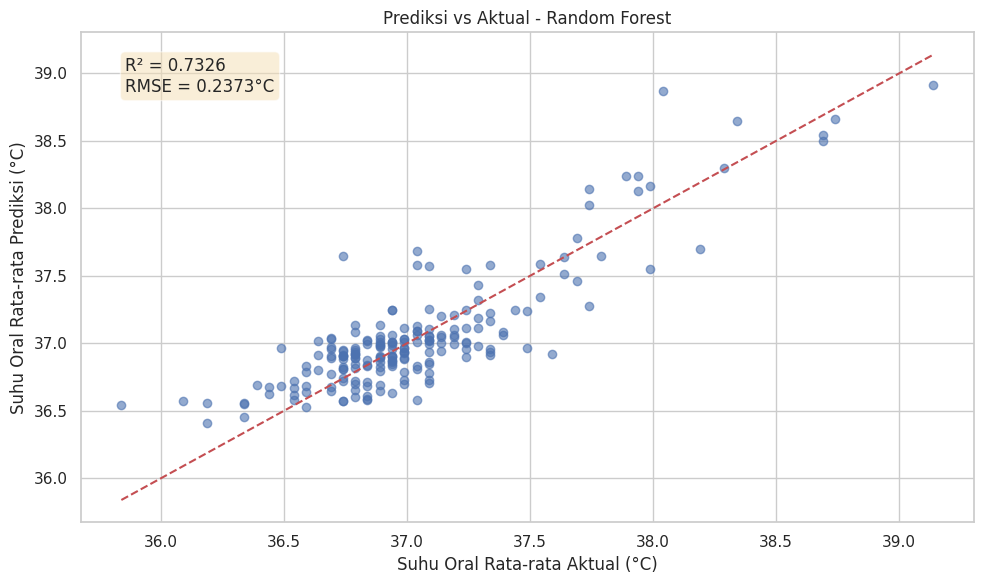

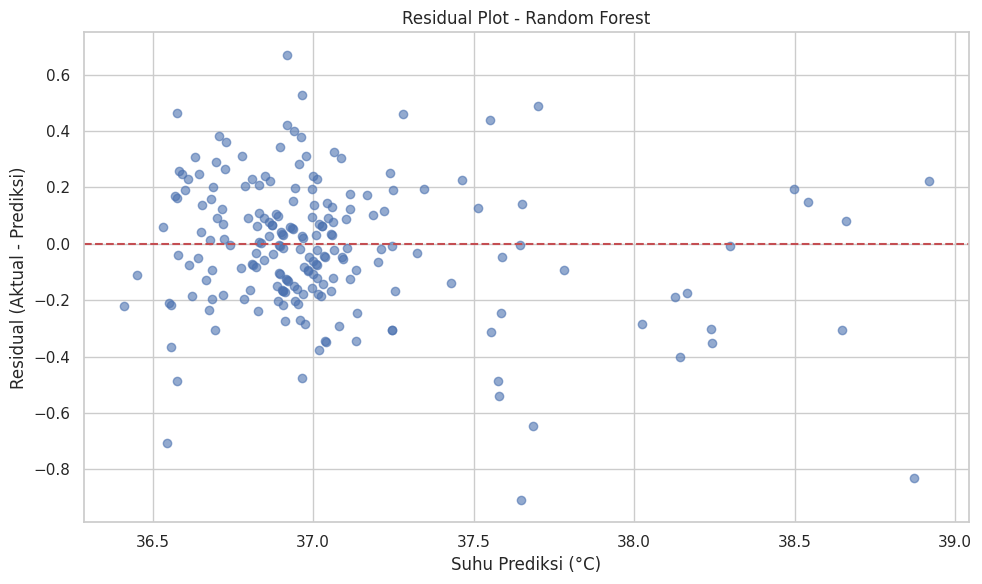

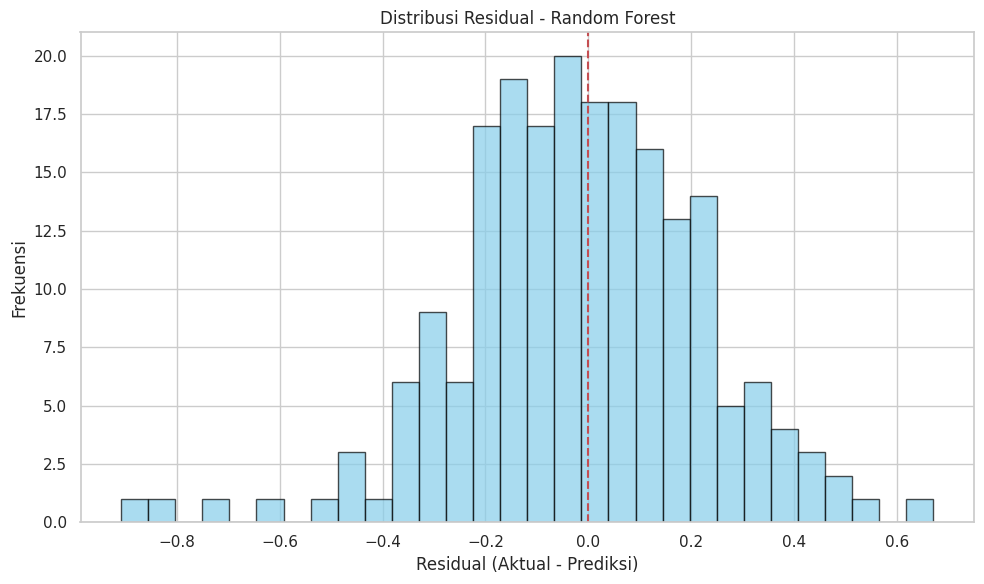

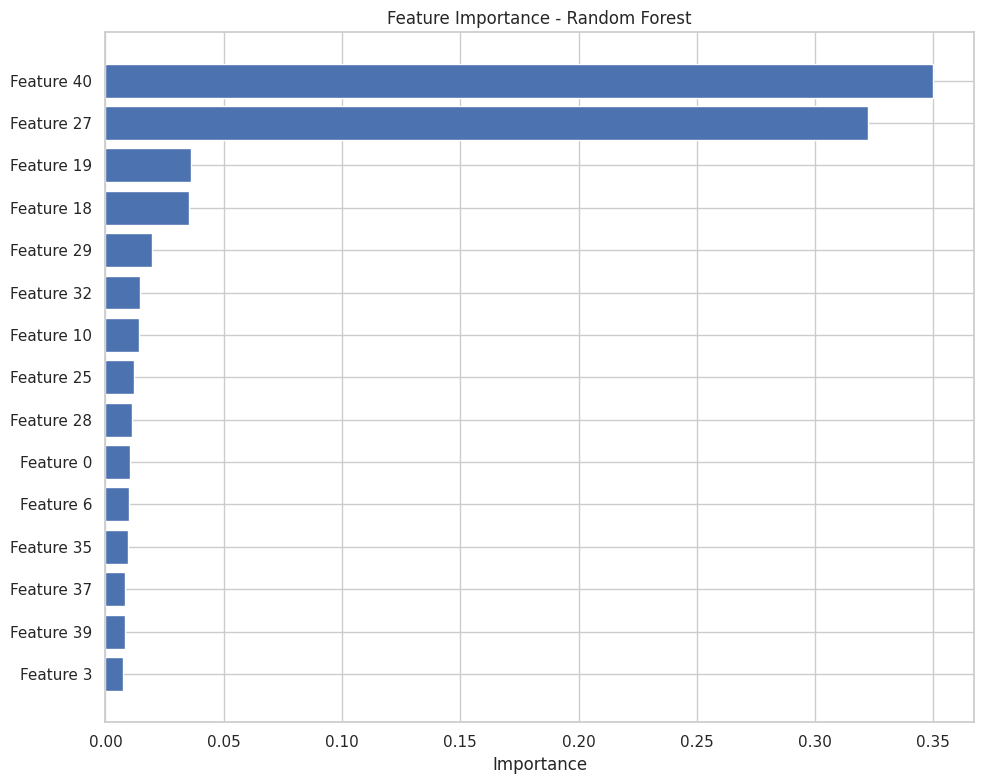

In [65]:
# Model Random Forest (Bagging)
print("=== Model Random Forest (Bagging) ===")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf_results = evaluate_model(rf_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)
# Visualisasi Random Forest untuk Infrared.csv
print("\n=== Visualisasi Model Random Forest - Infrared Dataset ===")

# 1. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_results['y_test_pred'], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Prediksi vs Aktual - Random Forest')
plt.xlabel('Suhu Oral Rata-rata Aktual (°C)')
plt.ylabel('Suhu Oral Rata-rata Prediksi (°C)')
plt.grid(True)
plt.text(0.05, 0.95, f'R² = {rf_results["test_r2"]:.4f}\nRMSE = {rf_results["test_rmse"]:.4f}°C',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_test - rf_results['y_test_pred']
plt.figure(figsize=(10, 6))
plt.scatter(rf_results['y_test_pred'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot - Random Forest')
plt.xlabel('Suhu Prediksi (°C)')
plt.ylabel('Residual (Aktual - Prediksi)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Histogram Residual
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribusi Residual - Random Forest')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Feature Importance
if hasattr(rf_results['model'], 'feature_importances_'):
    importances = rf_results['model'].feature_importances_
    indices = np.argsort(importances)[-15:] if len(importances) > 15 else np.argsort(importances)
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.title('Feature Importance - Random Forest')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

## 6. Pemodelan dengan Teknik Boosting


=== Model Gradient Boosting Regressor ===
Training MSE: 0.025463
Testing MSE: 0.052325
Training RMSE: 0.159572
Testing RMSE: 0.228747
Training R²: 0.906220
Testing R²: 0.751509

=== Visualisasi Model Gradient Boosting - Infrared Dataset ===


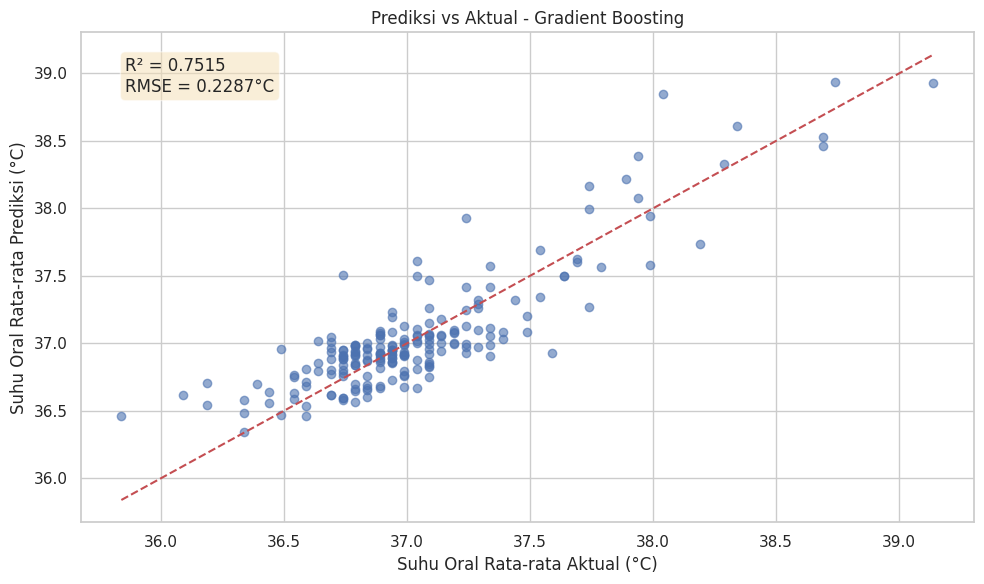

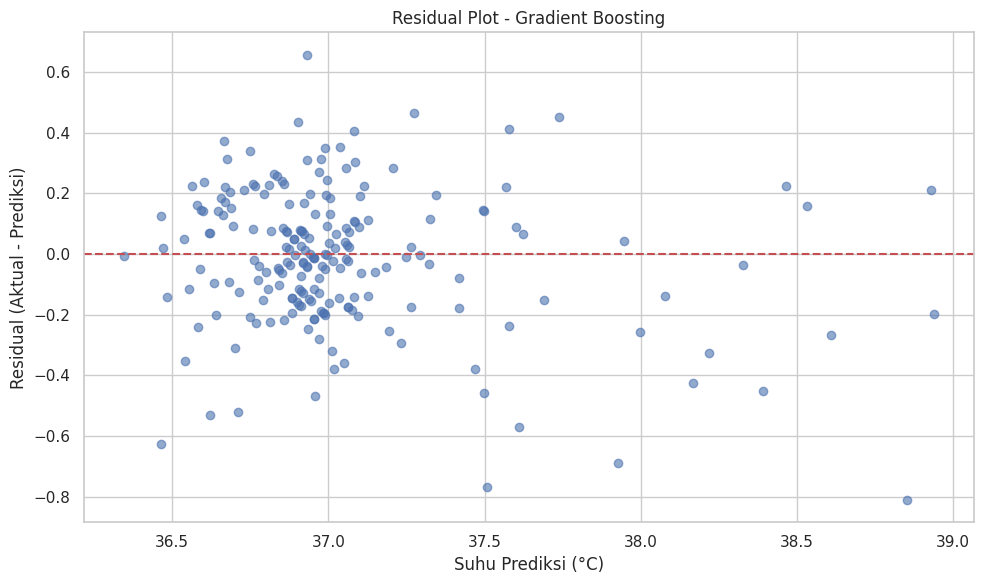

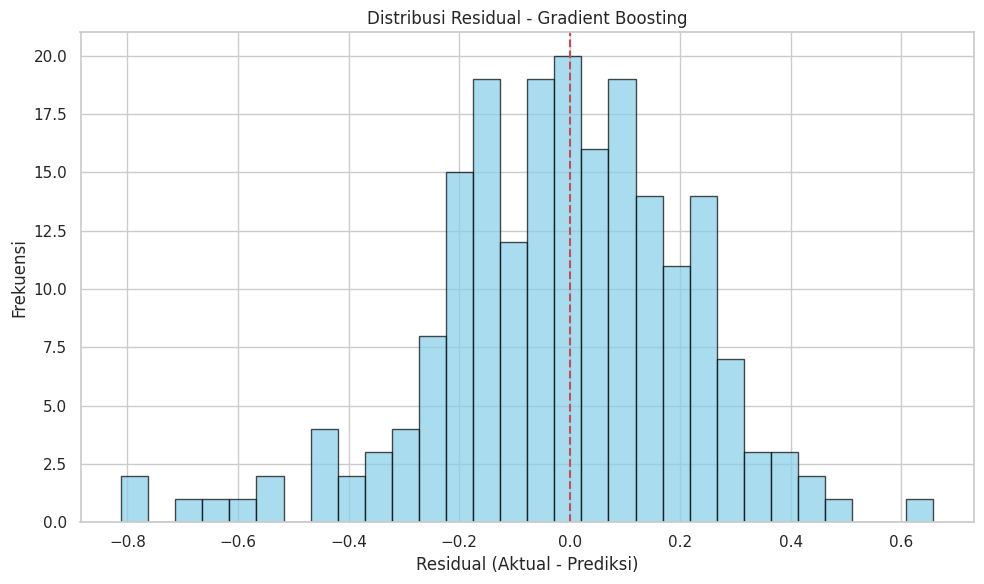

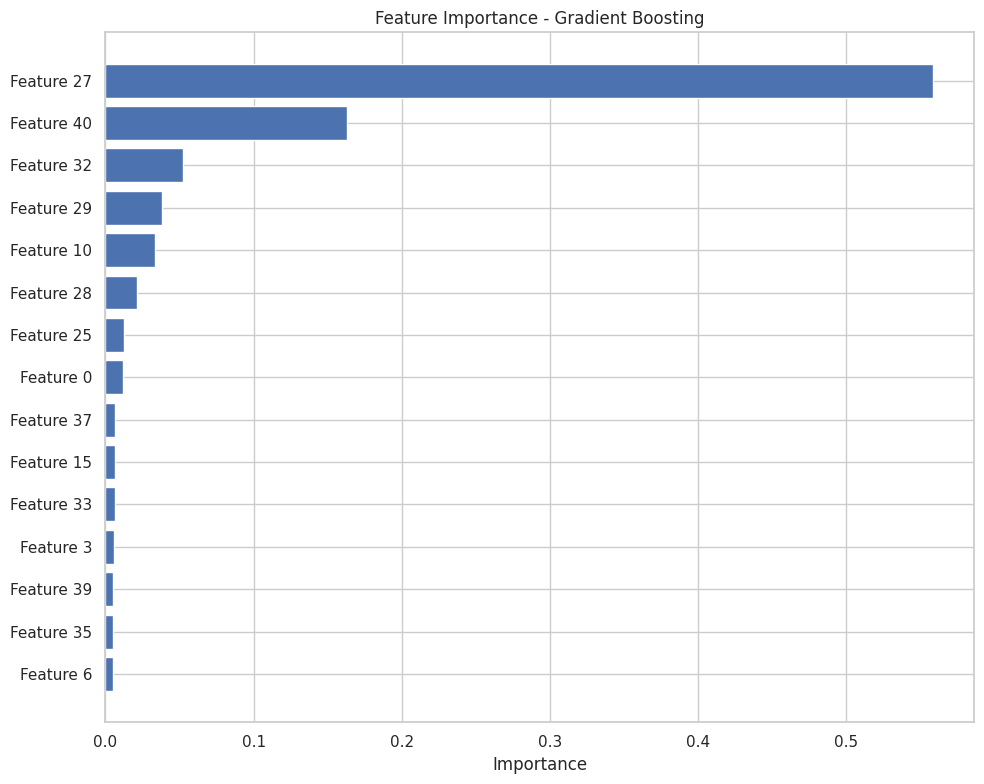

In [66]:
# 1. Gradient Boosting Regressor
print("\n=== Model Gradient Boosting Regressor ===")
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_results = evaluate_model(gb_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)
# Visualisasi Gradient Boosting untuk Infrared.csv
print("\n=== Visualisasi Model Gradient Boosting - Infrared Dataset ===")

# 1. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gb_results['y_test_pred'], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Prediksi vs Aktual - Gradient Boosting')
plt.xlabel('Suhu Oral Rata-rata Aktual (°C)')
plt.ylabel('Suhu Oral Rata-rata Prediksi (°C)')
plt.grid(True)
plt.text(0.05, 0.95, f'R² = {gb_results["test_r2"]:.4f}\nRMSE = {gb_results["test_rmse"]:.4f}°C',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_test - gb_results['y_test_pred']
plt.figure(figsize=(10, 6))
plt.scatter(gb_results['y_test_pred'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot - Gradient Boosting')
plt.xlabel('Suhu Prediksi (°C)')
plt.ylabel('Residual (Aktual - Prediksi)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Histogram Residual
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribusi Residual - Gradient Boosting')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Feature Importance
if hasattr(gb_results['model'], 'feature_importances_'):
    importances = gb_results['model'].feature_importances_
    indices = np.argsort(importances)[-15:] if len(importances) > 15 else np.argsort(importances)
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.title('Feature Importance - Gradient Boosting')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()


=== Model AdaBoost Regressor ===
Training MSE: 0.053056
Testing MSE: 0.056528
Training RMSE: 0.230339
Testing RMSE: 0.237756
Training R²: 0.804597
Testing R²: 0.731550

=== Visualisasi Model AdaBoost - Infrared Dataset ===


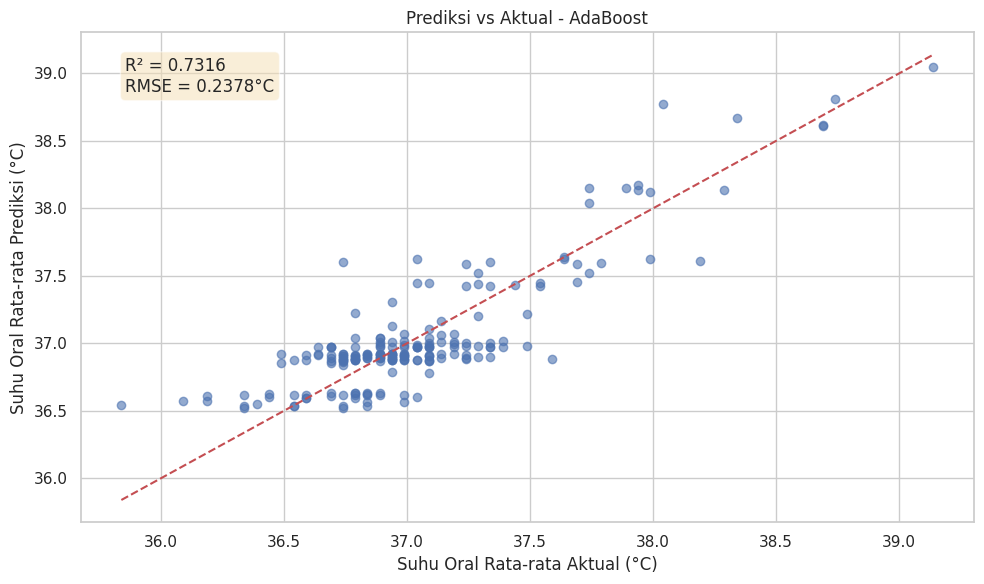

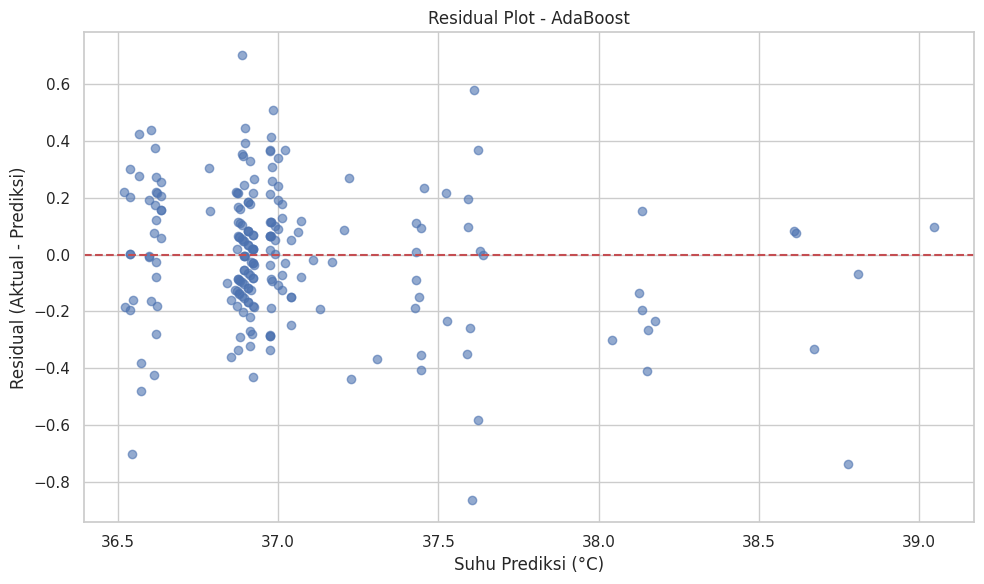

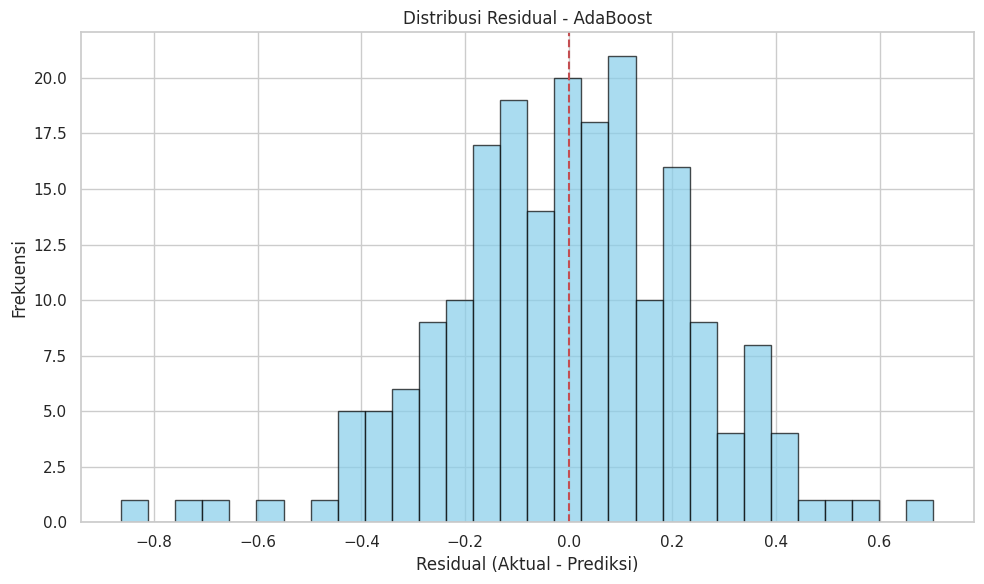

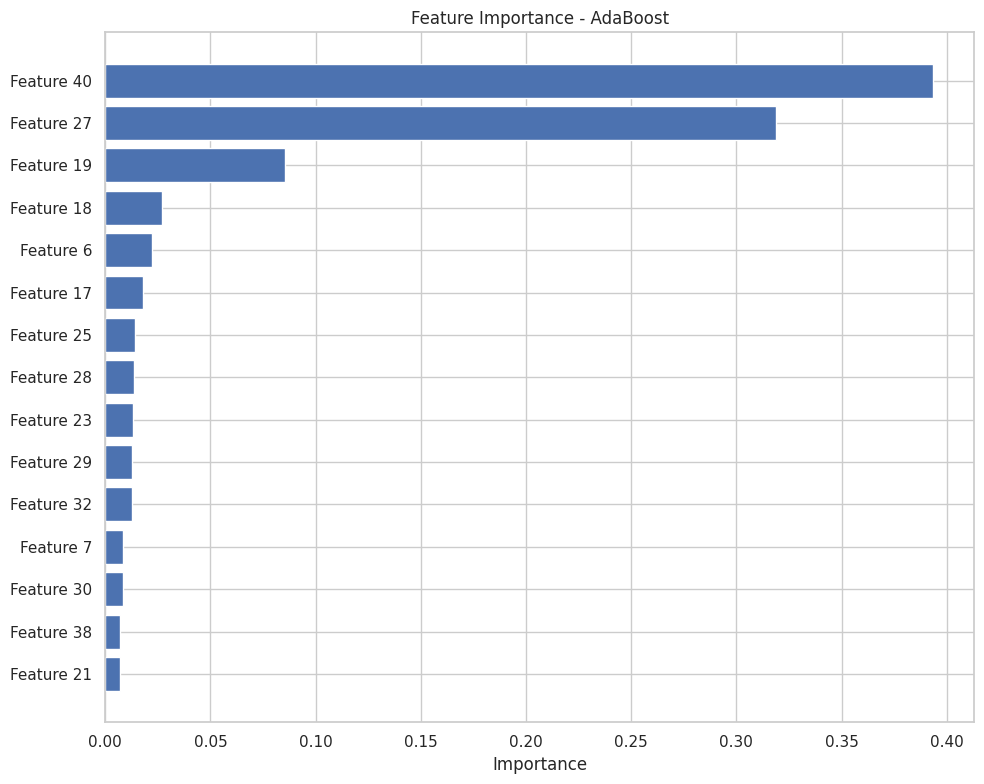

In [67]:
# 2. AdaBoost Regressor
print("\n=== Model AdaBoost Regressor ===")
ada_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
ada_results = evaluate_model(ada_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)
# Visualisasi AdaBoost untuk Infrared.csv
print("\n=== Visualisasi Model AdaBoost - Infrared Dataset ===")

# 1. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ada_results['y_test_pred'], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Prediksi vs Aktual - AdaBoost')
plt.xlabel('Suhu Oral Rata-rata Aktual (°C)')
plt.ylabel('Suhu Oral Rata-rata Prediksi (°C)')
plt.grid(True)
plt.text(0.05, 0.95, f'R² = {ada_results["test_r2"]:.4f}\nRMSE = {ada_results["test_rmse"]:.4f}°C',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_test - ada_results['y_test_pred']
plt.figure(figsize=(10, 6))
plt.scatter(ada_results['y_test_pred'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot - AdaBoost')
plt.xlabel('Suhu Prediksi (°C)')
plt.ylabel('Residual (Aktual - Prediksi)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Histogram Residual
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribusi Residual - AdaBoost')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Feature Importance
if hasattr(ada_results['model'], 'feature_importances_'):
    importances = ada_results['model'].feature_importances_
    indices = np.argsort(importances)[-15:] if len(importances) > 15 else np.argsort(importances)
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.title('Feature Importance - AdaBoost')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()


=== Model XGBoost Regressor ===
Training MSE: 0.027493
Testing MSE: 0.050217
Training RMSE: 0.165811
Testing RMSE: 0.224091
Training R²: 0.898744
Testing R²: 0.761522

=== Visualisasi Model XGBoost - Infrared Dataset ===


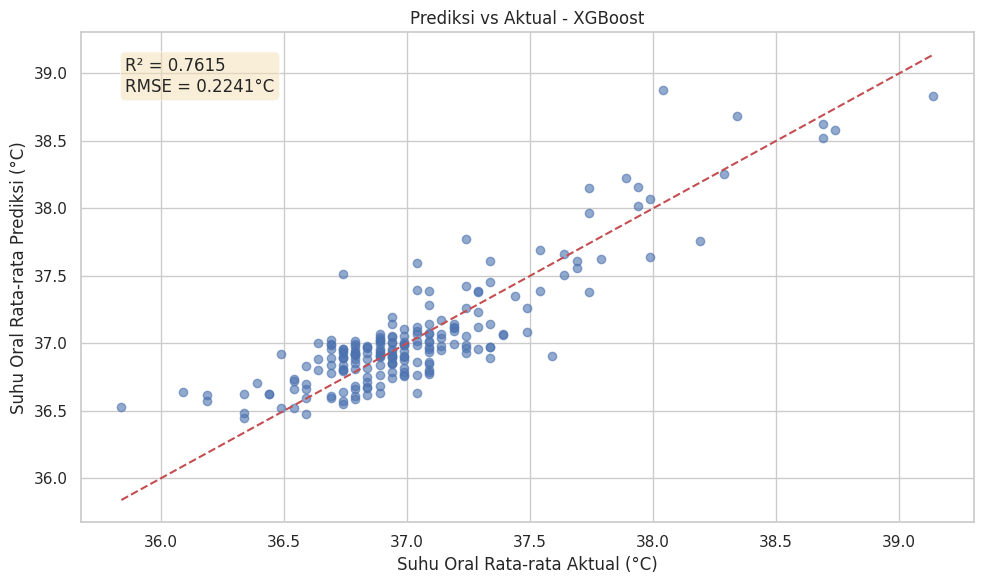

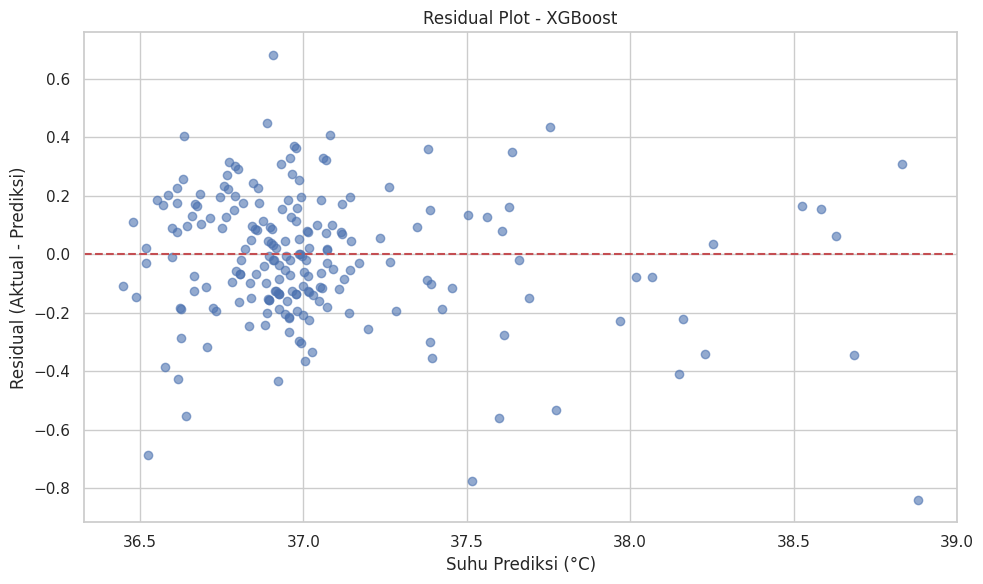

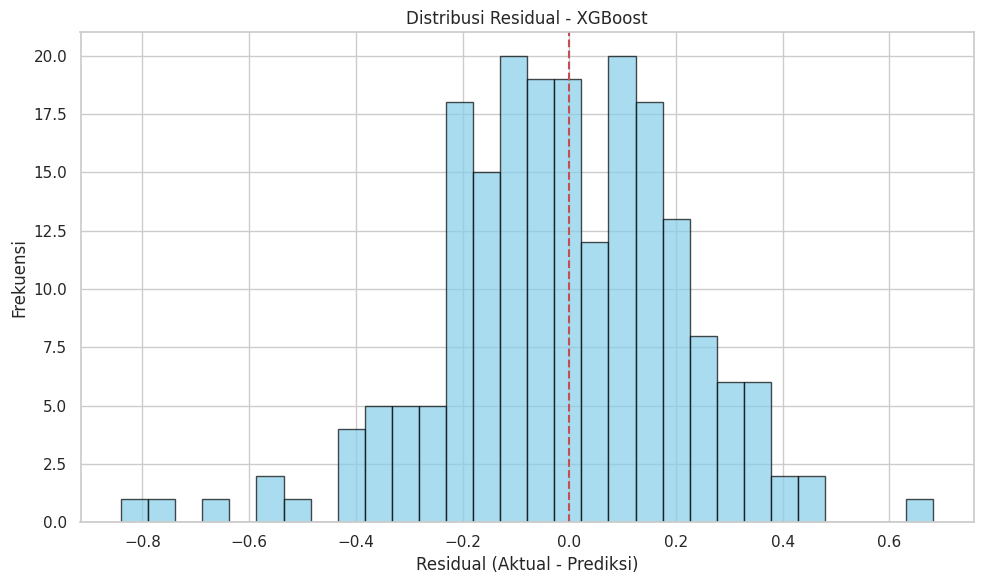

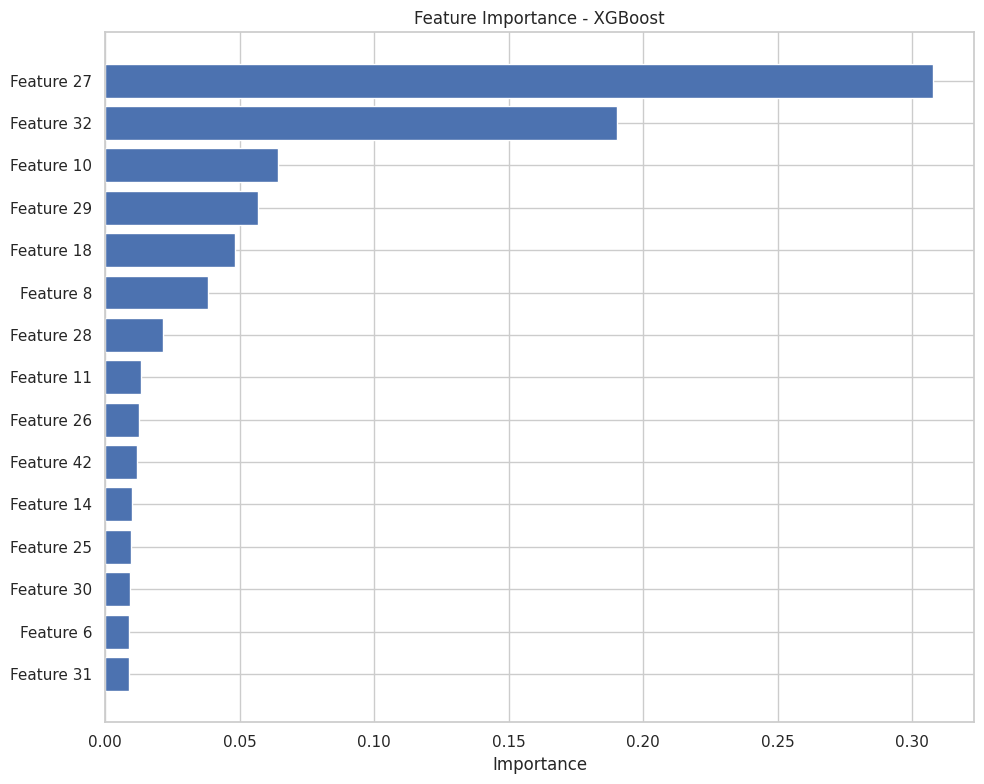

<Figure size 1200x800 with 0 Axes>

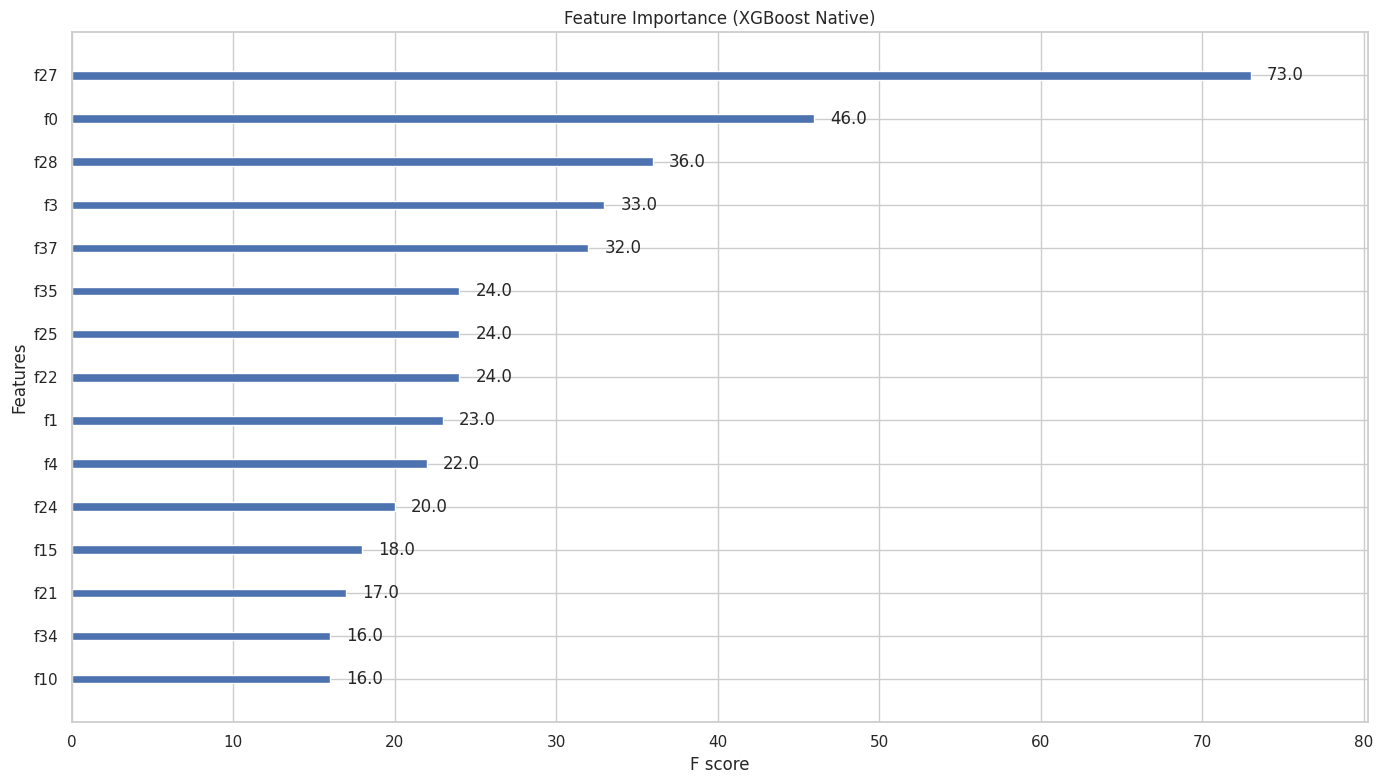

In [68]:
# 3. XGBoost Regressor
print("\n=== Model XGBoost Regressor ===")
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_results = evaluate_model(xgb_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)
# Visualisasi XGBoost untuk Infrared.csv
print("\n=== Visualisasi Model XGBoost - Infrared Dataset ===")

# 1. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_results['y_test_pred'], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Prediksi vs Aktual - XGBoost')
plt.xlabel('Suhu Oral Rata-rata Aktual (°C)')
plt.ylabel('Suhu Oral Rata-rata Prediksi (°C)')
plt.grid(True)
plt.text(0.05, 0.95, f'R² = {xgb_results["test_r2"]:.4f}\nRMSE = {xgb_results["test_rmse"]:.4f}°C',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

# 2. Residual Plot
residuals = y_test - xgb_results['y_test_pred']
plt.figure(figsize=(10, 6))
plt.scatter(xgb_results['y_test_pred'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot - XGBoost')
plt.xlabel('Suhu Prediksi (°C)')
plt.ylabel('Residual (Aktual - Prediksi)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Histogram Residual
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribusi Residual - XGBoost')
plt.xlabel('Residual (Aktual - Prediksi)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Feature Importance
if hasattr(xgb_results['model'], 'feature_importances_'):
    importances = xgb_results['model'].feature_importances_
    indices = np.argsort(importances)[-15:] if len(importances) > 15 else np.argsort(importances)
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.title('Feature Importance - XGBoost')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    # Bonus: Visualisasi native XGBoost (jika berjalan)
    try:
        plt.figure(figsize=(12, 8))
        xgb.plot_importance(xgb_results['model'], max_num_features=15)
        plt.title('Feature Importance (XGBoost Native)')
        plt.tight_layout()
        plt.show()
    except:
        pass

## 7. Perbandingan Model

In [69]:
# Perbandingan model
models = {
    'Random Forest (Bagging)': rf_results,
    'Gradient Boosting': gb_results,
    'AdaBoost': ada_results,
    'XGBoost': xgb_results
}

# Perbandingan metrik
comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Train MSE': [models[k]['train_mse'] for k in models.keys()],
    'Test MSE': [models[k]['test_mse'] for k in models.keys()],
    'Train RMSE': [models[k]['train_rmse'] for k in models.keys()],
    'Test RMSE': [models[k]['test_rmse'] for k in models.keys()],
    'Train R²': [models[k]['train_r2'] for k in models.keys()],
    'Test R²': [models[k]['test_r2'] for k in models.keys()]
})

comparison_df.sort_values('Test R²', ascending=False)

,Model,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R²,Test R²
3,XGBoost,0.027493,0.050217,0.165811,0.224091,0.898744,0.761522
1,Gradient Boosting,0.025463,0.052325,0.159572,0.228747,0.906220,0.751509
0,Random Forest (Bagging),0.009467,0.056304,0.097297,0.237285,0.965134,0.732613
2,AdaBoost,0.053056,0.056528,0.230339,0.237756,0.804597,0.731550


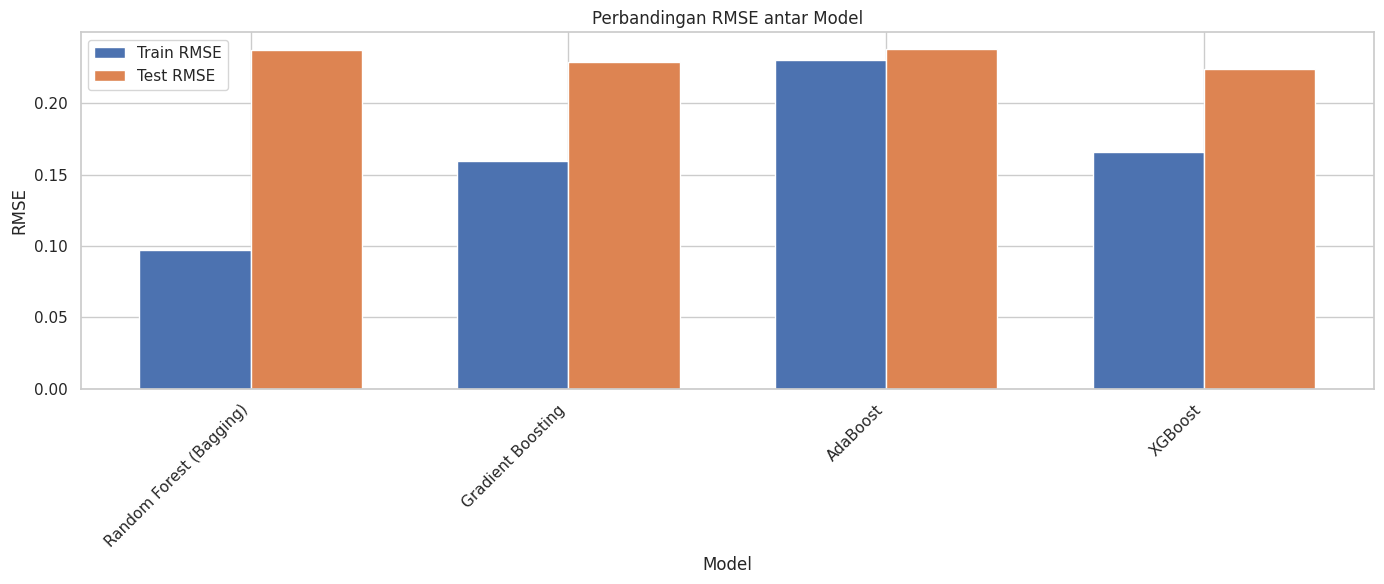

In [70]:
# Visualisasi perbandingan RMSE
plt.figure(figsize=(14, 6))
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, [models[k]['train_rmse'] for k in models.keys()], bar_width, label='Train RMSE')
plt.bar(index + bar_width, [models[k]['test_rmse'] for k in models.keys()], bar_width, label='Test RMSE')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Perbandingan RMSE antar Model')
plt.xticks(index + bar_width / 2, list(models.keys()), rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

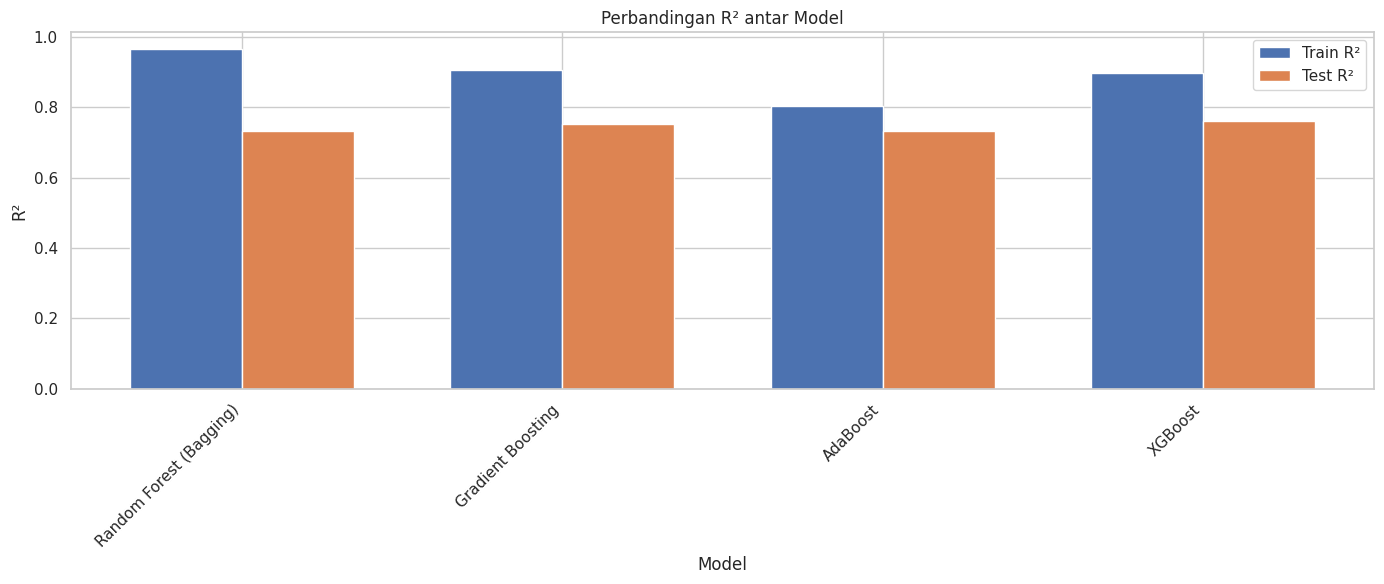

In [71]:
# Visualisasi perbandingan R²
plt.figure(figsize=(14, 6))
plt.bar(index, [models[k]['train_r2'] for k in models.keys()], bar_width, label='Train R²')
plt.bar(index + bar_width, [models[k]['test_r2'] for k in models.keys()], bar_width, label='Test R²')

plt.xlabel('Model')
plt.ylabel('R²')
plt.title('Perbandingan R² antar Model')
plt.xticks(index + bar_width / 2, list(models.keys()), rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

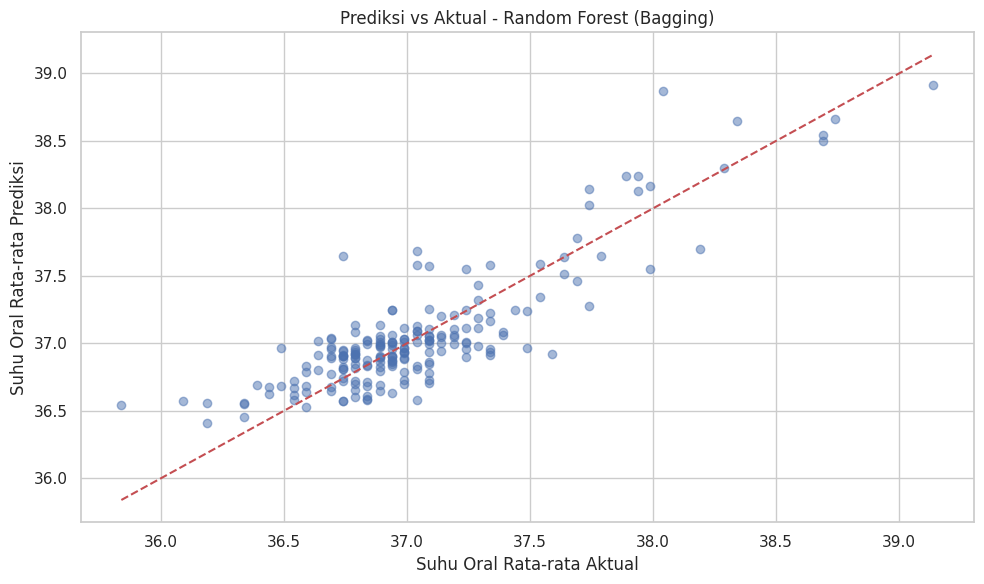

In [72]:
# Visualisasi prediksi vs aktual untuk model terbaik
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = models[best_model_name]

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model_results['y_test_pred'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Suhu Oral Rata-rata Aktual')
plt.ylabel('Suhu Oral Rata-rata Prediksi')
plt.title(f'Prediksi vs Aktual - {best_model_name}')
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Analisis Feature Importance

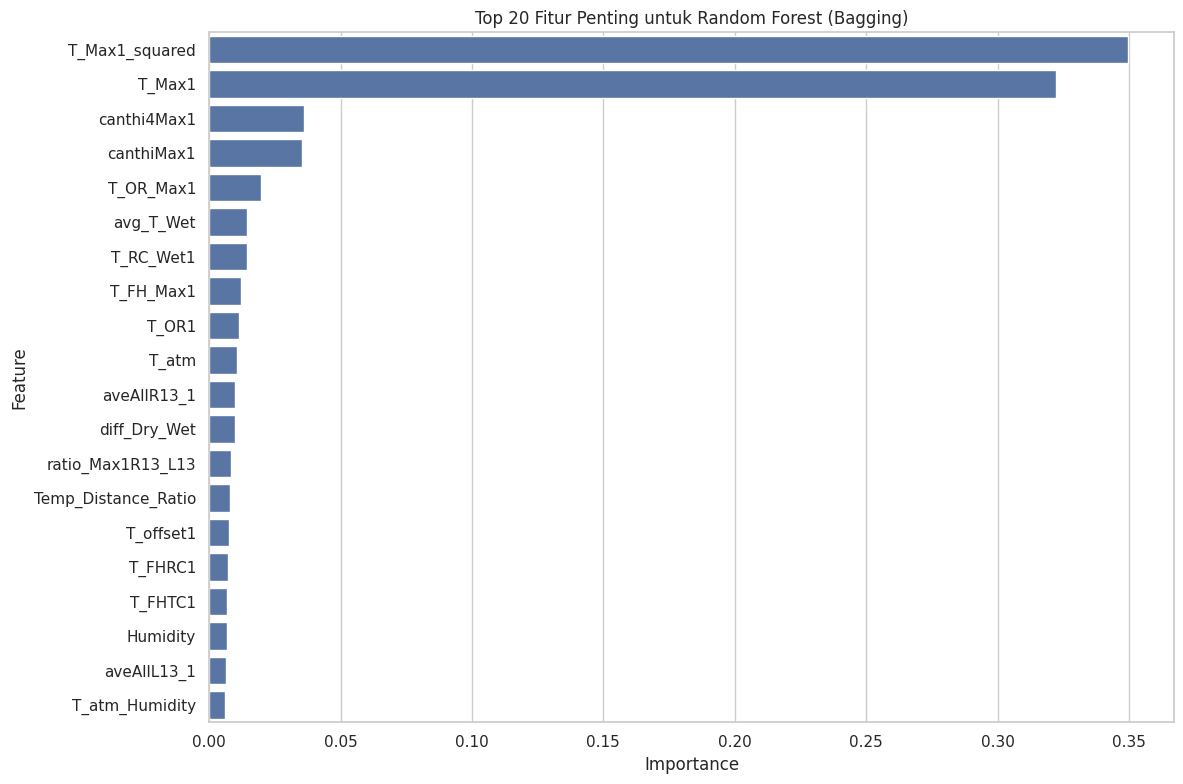

Top 20 Fitur Penting:
                Feature  Importance
40       T_Max1_squared    0.349665
27               T_Max1    0.322322
19          canthi4Max1    0.036014
18           canthiMax1    0.035414
29            T_OR_Max1    0.019720
32            avg_T_Wet    0.014581
10            T_RC_Wet1    0.014348
25            T_FH_Max1    0.012253
28                T_OR1    0.011292
0                 T_atm    0.010455
6           aveAllR13_1    0.009927
35         diff_Dry_Wet    0.009708
37    ratio_Max1R13_L13    0.008462
39  Temp_Distance_Ratio    0.008132
3             T_offset1    0.007454
21              T_FHRC1    0.007079
24              T_FHTC1    0.006835
1              Humidity    0.006614
7           aveAllL13_1    0.006269
38       T_atm_Humidity    0.006115


In [73]:
# Analisis feature importance untuk model terbaik
best_model = best_model_results['model']

# Jika model mendukung feature importance
if hasattr(best_model, 'feature_importances_'):
    # Mendapatkan feature importance
    importances = best_model.feature_importances_

    # Mendapatkan nama fitur setelah preprocessing
    # Catatan: Ini hanya perkiraan, karena setelah preprocessing, nama fitur sebenarnya bisa berbeda
    # terutama untuk fitur kategorikal yang di-one-hot-encoded

    # Mencoba mendapatkan nama fitur dari preprocessor
    try:
        feature_names = []
        # Untuk fitur numerik
        feature_names.extend(numeric_features)
        # Untuk fitur kategorikal (one-hot-encoded)
        for cat_feature in categorical_features:
            unique_values = X_train[cat_feature].unique()
            for value in unique_values:
                feature_names.append(f"{cat_feature}_{value}")

        # Memastikan jumlah nama fitur sama dengan jumlah feature importance
        if len(feature_names) != len(importances):
            feature_names = [f"Feature_{i}" for i in range(len(importances))]
    except:
        # Jika gagal, gunakan nama generik
        feature_names = [f"Feature_{i}" for i in range(len(importances))]

    # Membuat DataFrame feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Visualisasi top 20 fitur penting
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title(f'Top 20 Fitur Penting untuk {best_model_name}')
    plt.tight_layout()
    plt.show()

    # Menampilkan top 20 fitur penting
    print("Top 20 Fitur Penting:")
    print(feature_importance_df.head(20))

## 9. Kesimpulan

Dari hasil analisis dan pemodelan dataset Infrared, kita dapat menarik beberapa kesimpulan:

1. Model terbaik untuk memprediksi suhu oral rata-rata (aveOralM) adalah _____ dengan R² pada data testing sebesar _____.
2. Fitur-fitur yang paling berpengaruh dalam memprediksi suhu oral rata-rata meliputi _____, yang menunjukkan bahwa pengukuran suhu pada area-area tersebut memiliki korelasi tinggi dengan suhu oral.
3. Feature engineering yang dilakukan, seperti menghitung rata-rata, selisih, dan rasio suhu pada berbagai lokasi, terbukti membantu meningkatkan performa model.
4. Terdapat perbedaan performa antara teknik Bagging (Random Forest) dan Boosting (Gradient Boosting, AdaBoost, XGBoost) dalam memprediksi suhu oral.
5. Faktor demografi seperti Gender, Age, dan Ethnicity memiliki pengaruh terhadap suhu oral, meskipun pengaruhnya tidak sebesar pengukuran suhu langsung dari infrared.

Untuk meningkatkan performa model, bisa dilakukan hyperparameter tuning yang lebih mendalam, mencoba teknik feature selection untuk mengurangi dimensi data, dan mempertimbangkan interaksi yang lebih kompleks antara fitur demografi dan pengukuran suhu.

## 10. Penjelasan Matematis

### 10.1 Teknik Bagging (Bootstrap Aggregating)

Bagging adalah teknik ensemble learning yang menggabungkan beberapa model yang dilatih pada subset data berbeda untuk mengurangi varians dan mencegah overfitting.

**Persamaan matematis:**

1. **Bootstrap Sampling**:
   - Dari dataset training $D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$, ambil $B$ sampel bootstrap dengan pengembalian, masing-masing berukuran $n$.
   - Setiap sampel bootstrap $D_b$ memiliki probabilitas $P(x_i \in D_b) = 1 - (1 - \frac{1}{n})^n \approx 1 - \frac{1}{e} \approx 0.632$ untuk setiap observasi asli.

2. **Pelatihan Model Base**:
   - Untuk setiap sampel bootstrap $D_b$, latih model base (misal decision tree) $f_b$.

3. **Prediksi Aggregated**:
   - Untuk data baru $x$, prediksi akhir adalah rata-rata atau voting dari semua model base:
     
     Untuk regresi (rata-rata):
     $f_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B} f_b(x)$
     
     Untuk klasifikasi (voting):
     $f_{bag}(x) = \text{mode}\{f_1(x), f_2(x), ..., f_B(x)\}$

4. **Random Forest**:
   - Random Forest menerapkan bagging dengan tambahan randomisasi dalam pemilihan fitur:
   - Pada setiap node, hanya subset acak dari fitur ($m < p$, dimana $p$ adalah jumlah total fitur) yang dipertimbangkan.
   - Biasanya $m = \sqrt{p}$ untuk klasifikasi, dan $m = p/3$ untuk regresi.
   - Randomisasi ini meningkatkan keragaman antar tree, yang mengurangi korelasi antar tree dan lebih efektif mengurangi varians.

### 10.2 Teknik Boosting

Boosting adalah teknik ensemble learning yang melatih model secara sekuensial, dengan setiap model baru berusaha memperbaiki kesalahan dari model sebelumnya.

#### Gradient Boosting

Gradient Boosting mengoptimalkan fungsi loss secara iteratif menggunakan gradient descent dalam fungsi ruang.

**Persamaan matematis:**

1. **Inisialisasi Model**:
   - $F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, \gamma)$
   - Untuk MSE, ini adalah nilai rata-rata target: $F_0(x) = \frac{1}{n} \sum_{i=1}^{n} y_i$

2. **Iterasi untuk $m = 1, 2, ..., M$**:
   - Hitung negatif gradient (residual) dari fungsi loss:
     $r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}}$
     
     Untuk MSE, ini adalah: $r_{im} = y_i - F_{m-1}(x_i)$
   
   - Latih model lemah $h_m(x)$ untuk memprediksi residual
   
   - Cari koefisien optimal:
     $\gamma_m = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$
   
   - Update model:
     $F_m(x) = F_{m-1}(x) + \eta \cdot \gamma_m h_m(x)$
     
     dimana $\eta$ adalah learning rate yang mengontrol kecepatan pembelajaran.

3. **Model Akhir**:
   - $F_M(x) = F_0(x) + \sum_{m=1}^{M} \eta \cdot \gamma_m h_m(x)$

#### AdaBoost (Adaptive Boosting)

AdaBoost menyesuaikan bobot sampel secara adaptif, memberikan bobot lebih tinggi pada sampel yang sulit diprediksi.

**Persamaan matematis untuk regresi:**

1. **Inisialisasi bobot sampel**: $w_i^{(1)} = \frac{1}{n}$ untuk semua $i = 1, 2, ..., n$

2. **Untuk iterasi $t = 1, 2, ..., T$**:
   - Latih model lemah $h_t(x)$ menggunakan bobot $w_i^{(t)}$
   
   - Hitung error rata-rata tertimbang:
     $\epsilon_t = \frac{\sum_{i=1}^{n} w_i^{(t)} |y_i - h_t(x_i)|}{\sum_{i=1}^{n} w_i^{(t)}}$
   
   - Hitung bobot model:
     $\alpha_t = \ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$
   
   - Update bobot sampel:
     $w_i^{(t+1)} = w_i^{(t)} \cdot \exp(\alpha_t |y_i - h_t(x_i)|)$
   
   - Normalisasi bobot sampel:
     $w_i^{(t+1)} = \frac{w_i^{(t+1)}}{\sum_{j=1}^{n} w_j^{(t+1)}}$

3. **Model akhir**:
   - $f(x) = \frac{\sum_{t=1}^{T} \alpha_t h_t(x)}{\sum_{t=1}^{T} \alpha_t}$

#### XGBoost (eXtreme Gradient Boosting)

XGBoost memperluas Gradient Boosting dengan regularisasi dan implementasi yang sangat efisien.

**Persamaan matematis:**

1. **Fungsi Objektif**:
   - $Obj = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)$
   - $l$ adalah fungsi loss dan $\Omega$ adalah regularisasi

2. **Regularisasi untuk Decision Tree**:
   - $\Omega(f) = \gamma T + \frac{1}{2}\lambda||w||^2$
   - $T$ adalah jumlah daun, $w$ adalah bobot daun, $\gamma$ dan $\lambda$ adalah parameter regularisasi

3. **Aproksimasi Taylor Orde Kedua**:
   - $Obj^{(t)} \approx \sum_{i=1}^{n} [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)$
   - $g_i = \frac{\partial l(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}}$ adalah gradient orde pertama
   - $h_i = \frac{\partial^2 l(y_i, \hat{y}_i^{(t-1)})}{\partial (\hat{y}_i^{(t-1)})^2}$ adalah gradient orde kedua

4. **Optimasi Struktur Tree**:
   - XGBoost menggunakan pendekatan greedy untuk membangun tree secara level-by-level
   - Untuk setiap split potensial, XGBoost menghitung pengurangan loss:
     $Gain = \frac{1}{2} \left[ \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} \right] - \gamma$
     dimana $G_L$ dan $G_R$ adalah jumlah gradient orde pertama di node kiri dan kanan, $H_L$ dan $H_R$ adalah jumlah gradient orde kedua

### 10.3 Metrik Evaluasi

#### Mean Squared Error (MSE)

MSE mengukur rata-rata kuadrat selisih antara nilai prediksi dan nilai aktual:

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

dimana $y_i$ adalah nilai aktual, $\hat{y}_i$ adalah nilai prediksi, dan $n$ adalah jumlah sampel.

**Interpretasi matematis**:
- MSE adalah varians dari residual plus kuadrat bias
- MSE merupakan fungsi loss kuadratik (L2) yang meminimalkan jumlah kuadrat error
- MSE memberikan penalti yang lebih besar untuk error besar karena sifat kuadratiknya
- MSE selalu non-negatif dan nilai MSE mendekati 0 menunjukkan fit model yang sempurna

#### Root Mean Squared Error (RMSE)

RMSE adalah akar kuadrat dari MSE:

$RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

**Interpretasi matematis**:
- RMSE memiliki unit yang sama dengan variabel target, sehingga lebih mudah diinterpretasikan
- RMSE merupakan L2-norm dari residual dibagi dengan akar jumlah sampel
- RMSE dapat diinterpretasikan sebagai standar deviasi dari residual
- RMSE juga memberikan penalti lebih besar untuk error besar

#### Coefficient of Determination (R²)

R² mengukur proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh model:

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$

dimana $SS_{res}$ adalah jumlah kuadrat residual, $SS_{tot}$ adalah jumlah kuadrat total, dan $\bar{y}$ adalah rata-rata nilai aktual.

**Interpretasi matematis**:
- R² = 1 - (MSE / Varians target): rasio antara MSE dan varians target
- R² = Proporsi variasi yang dijelaskan oleh model / Total variasi
- R² bisa ditulis juga sebagai korelasi kuadrat antara nilai aktual dan prediksi untuk model linear tanpa intercept
- Untuk regresi linear dengan intercept, R² sama dengan koefisien korelasi Pearson kuadrat antara target dan prediksi
- R² < 0 menunjukkan model yang lebih buruk dari memprediksi nilai rata-rata
- R² = 0 menunjukkan model yang sama baiknya dengan memprediksi nilai rata-rata
- R² = 1 menunjukkan model yang sempurna yang menjelaskan 100% variasi dalam data

Ketiga metrik ini saling melengkapi dalam evaluasi model regresi. MSE dan RMSE fokus pada magnitude error absolut, sementara R² fokus pada kemampuan model untuk menjelaskan variasi dalam data relatif terhadap model naif yang hanya memprediksi rata-rata.